# Импорты

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso, LassoCV
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer, make_column_selector
from lightgbm import LGBMRegressor
from math import radians, sin, cos, sqrt, atan2
import warnings

warnings.filterwarnings('ignore')

## Линейная регрессия. Практика

В этом задании Вам предстоит применить на практике алгоритм линейной регрессии. В этом задании **запрещается** менять уже написанный код. Вы можете дописывать только свой код в указанных ячейках. Если ячейка пустая, вы **можете** создать дополнительные ячейки.

In [2]:
pd.set_option('display.max_columns', 40)

import matplotlib.pyplot as plt

# %matplotlib inline

import seaborn as sns

sns.set()
sns.set_style("whitegrid")

Мы будем работать с датасетом доставки готовой еды. В этой практике мы будем решать задачу **ETA (estimated time of arrival)** – предсказание времени доставки. Датасет содержит в себе информацию о нескольких поездках курьеров. Каждая поездка описывается следующим набором признаков:

- ID – уникальный идентификатор поездки;
- Delivery_person_ID – идентификатор курьера;
- Delivery_person_Age – возраст курьера;
- Delivery_person_Ratings – рейтинг курьера;
- Restaurant_latitude, Restaurant_longitude – координаты ресторана: широта и долгота;
- Delivery_location_latitude, Delivery_location_longitude – координаты клиента: широта и долгота;
- Order_Date – дата доставки;
- Time_Orderd – время, когда был принят заказ;
- Time_Order_picked – время, когда заказ был передан курьеру;
- Weather conditions – погодные условия;
- Road_traffic_density – плотность автомобилей на дороге;
- Vehicle_condition – состояние транспорта курьера;
- Type_of_order – тип заказа;
- Type_of_vehicle – вид транспорта курьера;
- multiple_deliveries – количество одновременных заказов у курьера;
- Festival – был ли заказ сделан с учетом промокода;
- City – регион доставки.

Ваша задача предсказать время доставки заказа – столбец Time_taken.

In [3]:
df = pd.read_csv('resources/eta-prediction-data.csv.gz', compression='gzip')

df.rename(columns={'Time_taken (min)': 'Time_taken'}, inplace=True)
df['Order_Date'] = pd.to_datetime(df['Order_Date'], format='%d-%m-%Y')

df['Road_traffic_density'] = pd.Categorical(
    df['Road_traffic_density'],
    categories=['Low', 'Medium', 'High', 'Jam'],
    ordered=True,
)

df['Festival'] = df['Festival'].fillna('No') == 'Yes'

df.head()

,ID,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Order_Date,Time_Orderd,Time_Order_picked,Weather conditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken
0,0x4607,INDORES13DEL02,37.0,4.9,22.745049,75.892471,22.765049,75.912471,2022-03-19,11:30,11:45,Sunny,High,2,Snack,motorcycle,0.0,False,Urban,24.0
1,0xb379,BANGRES18DEL02,34.0,4.5,12.913041,77.683237,13.043041,77.813237,2022-03-25,19:45,19:50,Stormy,Jam,2,Snack,scooter,1.0,False,Metropolitian,33.0
2,0x20f7,BANGRES18DEL01,37.0,4.4,12.913041,77.683237,12.953041,77.723237,2022-03-19,13:50,13:55,Windy,High,0,Buffet,motorcycle,2.0,False,Metropolitian,42.0
3,0x7804,HYDRES13DEL02,28.0,4.9,17.431477,78.400350,17.451477,78.420350,2022-03-07,10:60,11:15,Sandstorms,Low,1,Meal,scooter,1.0,False,Urban,19.0
4,0x7faf,RANCHIRES07DEL01,37.0,4.6,23.359407,85.325055,23.429407,85.395055,2022-03-18,23:50,23:60,Stormy,Low,0,Meal,motorcycle,1.0,False,Metropolitian,25.0


Первые 5 строк данных:
       ID Delivery_person_ID  Delivery_person_Age  Delivery_person_Ratings  \
0  0x4607     INDORES13DEL02                 37.0                      4.9   
1  0xb379     BANGRES18DEL02                 34.0                      4.5   
2  0x20f7     BANGRES18DEL01                 37.0                      4.4   
3  0x7804      HYDRES13DEL02                 28.0                      4.9   
4  0x7faf   RANCHIRES07DEL01                 37.0                      4.6   

   Restaurant_latitude  Restaurant_longitude  Delivery_location_latitude  \
0            22.745049             75.892471                   22.765049   
1            12.913041             77.683237                   13.043041   
2            12.913041             77.683237                   12.953041   
3            17.431477             78.400350                   17.451477   
4            23.359407             85.325055                   23.429407   

   Delivery_location_longitude Order_Date Time_Orde

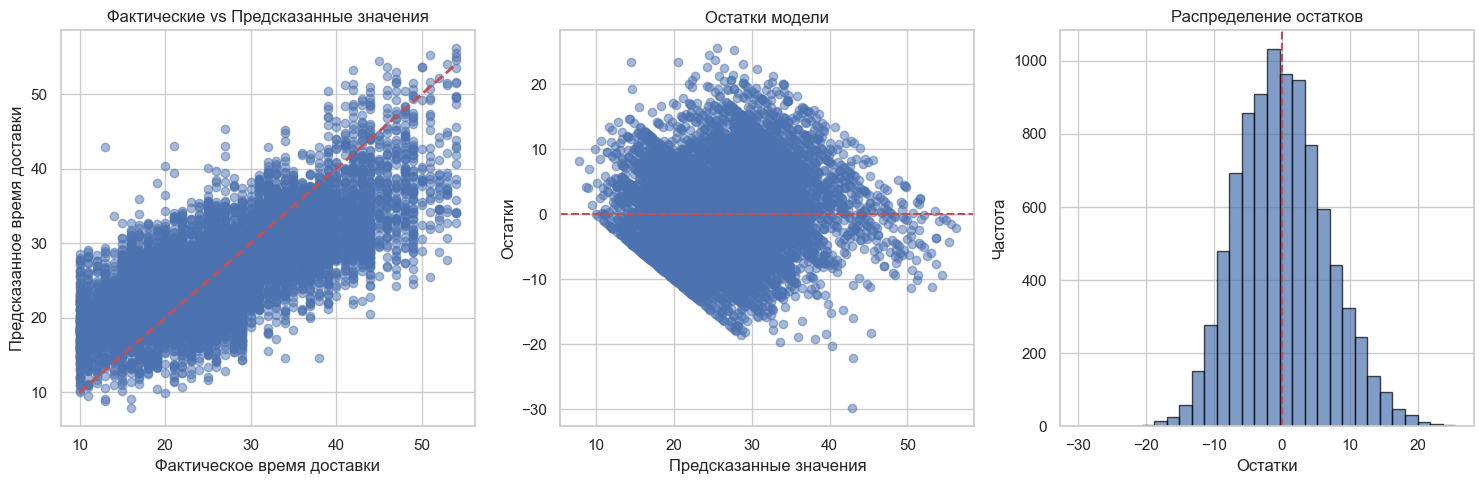

In [4]:
# Просмотр первых строк данных и информации о столбцах
print("Первые 5 строк данных:")
print(df.head())
print("\nИнформация о данных:")
print(df.info())
print("\nСтатистика данных:")
print(df.describe())

# Проверка пропущенных значений
print("\nПропущенные значения:")
print(df.isnull().sum())

# Обработка пропущенных значений
df.fillna(method='ffill', inplace=True)

# ДОПОЛНИТЕЛЬНО: Проверяем и преобразуем datetime столбцы
datetime_columns = df.select_dtypes(include=['datetime64', 'datetime64[ns]']).columns
print(f"\nОбнаружены datetime столбцы: {list(datetime_columns)}")

for column in datetime_columns:
    # Преобразуем datetime в числовые значения (количество дней с минимальной даты)
    df[column] = (df[column] - df[column].min()).dt.total_seconds() / (24 * 3600)  # в днях
    print(f"Преобразован datetime столбец {column} в числовой формат")

# Проверим, есть ли столбец Road_traffic_density и преобразуем его если нужно
if 'Road_traffic_density' in df.columns:
    # Если он категориальный, преобразуем в числовой
    if df['Road_traffic_density'].dtype.name == 'category':
        df['Road_traffic_density'] = df['Road_traffic_density'].cat.codes

# Преобразуем булевы значения в числовые
if 'Festival' in df.columns:
    df['Festival'] = df['Festival'].astype(int)

# Вычисление расстояния между рестораном и местом доставки
if all(col in df.columns for col in ['Restaurant_latitude', 'Restaurant_longitude', 
                                    'Delivery_location_latitude', 'Delivery_location_longitude']):
    df['distance_km'] = np.sqrt(
        (df['Delivery_location_latitude'] - df['Restaurant_latitude'])**2 +
        (df['Delivery_location_longitude'] - df['Restaurant_longitude'])**2
    ) * 111  # примерное преобразование в километры
    
    # Удаляем исходные координатные столбцы
    df = df.drop(['Restaurant_latitude', 'Restaurant_longitude', 
                 'Delivery_location_latitude', 'Delivery_location_longitude'], axis=1)

# Удаляем ID и Delivery_person_ID если они есть
columns_to_drop = ['ID', 'Delivery_person_ID']
df = df.drop(columns=[col for col in columns_to_drop if col in df.columns])

# Кодирование категориальных переменных
categorical_columns = df.select_dtypes(include=['object']).columns
label_encoders = {}

for column in categorical_columns:
    if column != 'Time_taken':  # исключаем целевую переменную
        le = LabelEncoder()
        df[column] = le.fit_transform(df[column].astype(str))
        label_encoders[column] = le
        print(f"Закодирован столбец: {column}")

# ДОПОЛНИТЕЛЬНО: Преобразуем все данные к числовому типу
for column in df.columns:
    if df[column].dtype.name not in ['int64', 'float64', 'int32', 'float32']:
        try:
            df[column] = pd.to_numeric(df[column], errors='coerce')
            print(f"Преобразован столбец {column} к числовому типу")
        except:
            print(f"Не удалось преобразовать столбец {column}")

# Проверяем, что все данные теперь числовые
print("\nТипы данных после обработки:")
print(df.dtypes)

# Проверяем на наличие NaN после преобразований
print("\nПропущенные значения после преобразований:")
print(df.isnull().sum())

# Заполняем возможные NaN после преобразований
df.fillna(0, inplace=True)

# Разделение на признаки и целевую переменную
X = df.drop('Time_taken', axis=1)
y = df['Time_taken']

print(f"\nРазмерность признаков: {X.shape}")
print(f"Размерность целевой переменной: {y.shape}")
print(f"Имена признаков: {list(X.columns)}")

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Масштабирование признаков
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Создание и обучение модели линейной регрессии
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# Предсказание на тестовой выборке
y_pred = model.predict(X_test_scaled)

# Оценка модели
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
mae = np.mean(np.abs(y_test - y_pred))

print(f"\nРезультаты модели:")
print(f"Mean Squared Error: {mse:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")
print(f"R-squared: {r2:.4f}")

# Визуализация результатов
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.xlabel('Фактическое время доставки')
plt.ylabel('Предсказанное время доставки')
plt.title('Фактические vs Предсказанные значения')

plt.subplot(1, 3, 2)
residuals = y_test - y_pred
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Предсказанные значения')
plt.ylabel('Остатки')
plt.title('Остатки модели')

plt.subplot(1, 3, 3)
plt.hist(residuals, bins=30, alpha=0.7, edgecolor='black')
plt.axvline(x=0, color='r', linestyle='--')
plt.xlabel('Остатки')
plt.ylabel('Частота')
plt.title('Распределение остатков')

plt.tight_layout()
plt.show()

### EDA (2 балла)

Выполните разведочный анализ данных. Для этого:
- Выведите размер таблицы;
- Посчитайте количество пропущенных значений.

Подумайте, какие столбцы вы хотите заполнить и какими значениями, а какие вообще не планируете использовать в своей модели.

=== РАЗВЕДОЧНЫЙ АНАЛИЗ ДАННЫХ (EDA) ===

1. РАЗМЕР ТАБЛИЦЫ:
Количество строк: 45593
Количество столбцов: 15
Общее количество элементов: 683895

2. ПРОПУЩЕННЫЕ ЗНАЧЕНИЯ:
                         Пропущено значений  Процент пропусков
Delivery_person_Age                       0                0.0
Delivery_person_Ratings                   0                0.0
Order_Date                                0                0.0
Time_Orderd                               0                0.0
Time_Order_picked                         0                0.0
Weather conditions                        0                0.0
Road_traffic_density                      0                0.0
Vehicle_condition                         0                0.0
Type_of_order                             0                0.0
Type_of_vehicle                           0                0.0
multiple_deliveries                       0                0.0
Festival                                  0                0.0
City        

<Figure size 1200x800 with 0 Axes>

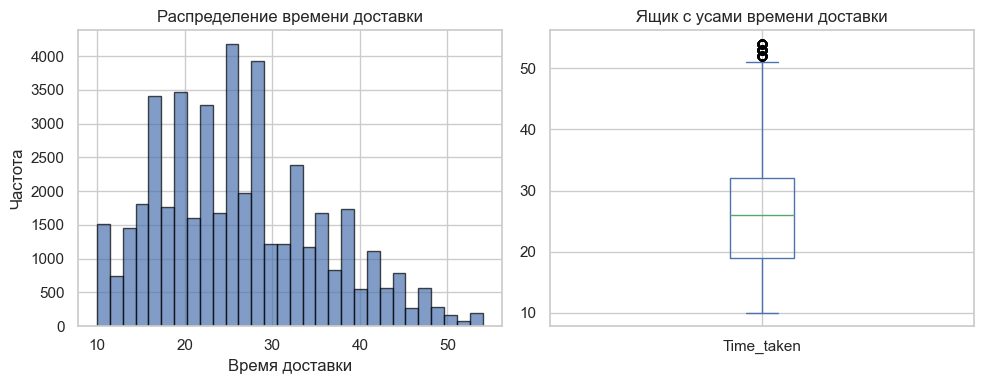

In [5]:
# EDA (Exploratory Data Analysis)
print("=== РАЗВЕДОЧНЫЙ АНАЛИЗ ДАННЫХ (EDA) ===\n")

# 1. Размер таблицы
print("1. РАЗМЕР ТАБЛИЦЫ:")
print(f"Количество строк: {df.shape[0]}")
print(f"Количество столбцов: {df.shape[1]}")
print(f"Общее количество элементов: {df.size}")

# 2. Пропущенные значения
print("\n2. ПРОПУЩЕННЫЕ ЗНАЧЕНИЯ:")
missing_values = df.isnull().sum()
missing_percentage = (df.isnull().sum() / len(df)) * 100

missing_info = pd.DataFrame({
    'Пропущено значений': missing_values,
    'Процент пропусков': missing_percentage.round(2)
})

print(missing_info)

# 3. Анализ типов данных
print("\n3. ТИПЫ ДАННЫХ:")
print(df.dtypes)

# 4. Основные статистики
print("\n4. ОСНОВНЫЕ СТАТИСТИКИ:")
print(df.describe())

# 5. Анализ категориальных переменных
print("\n5. КАТЕГОРИАЛЬНЫЕ ПЕРЕМЕННЫЕ:")
categorical_cols = df.select_dtypes(include=['object', 'category']).columns
print(f"Категориальные столбцы: {list(categorical_cols)}")

for col in categorical_cols:
    if col in df.columns:
        print(f"\n{col}:")
        print(f"Уникальных значений: {df[col].nunique()}")
        print(f"Топ-5 значений:")
        print(df[col].value_counts().head())

# 6. Визуализация пропущенных значений
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))
missing_data = df.isnull().sum()
missing_data = missing_data[missing_data > 0]

if len(missing_data) > 0:
    plt.subplot(1, 2, 1)
    missing_data.plot(kind='bar')
    plt.title('Количество пропущенных значений по столбцам')
    plt.xticks(rotation=45)
    
    plt.subplot(1, 2, 2)
    missing_percent = (missing_data / len(df)) * 100
    missing_percent.plot(kind='bar')
    plt.title('Процент пропущенных значений по столбцам')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()
else:
    print("Пропущенных значений нет!")

# 7. Анализ распределения целевой переменной
if 'Time_taken' in df.columns:
    plt.figure(figsize=(10, 4))
    
    plt.subplot(1, 2, 1)
    df['Time_taken'].hist(bins=30, alpha=0.7, edgecolor='black')
    plt.title('Распределение времени доставки')
    plt.xlabel('Время доставки')
    plt.ylabel('Частота')
    
    plt.subplot(1, 2, 2)
    df['Time_taken'].plot(kind='box')
    plt.title('Ящик с усами времени доставки')
    
    plt.tight_layout()
    plt.show()

Обратите внимание на значения в столбце `City`. Предлагается выполнить для столбца следующую предобработку данных:
- Значение `Semi-Urban` перевести в `Urban`;
- Пропущенные значения заполнить самым популярным значением.

Не забудьте указать категориальный тип у столбца `City`.

In [6]:
# Заменяем Semi–Urban на Urban
df['City'] = df['City'].replace('Semi–Urban', 'Urban')

# Находим самое популярное значение (исключая пропуски)
most_common_city = df['City'].value_counts().index[0]

# Заполняем пропуски самым популярным значением
df['City'] = df['City'].fillna(most_common_city)

# Устанавливаем категориальный тип данных
df['City'] = df['City'].astype('category')

# Проверяем распределение значений
print(df['City'].value_counts())

City
0    35021
2    10405
1      167
Name: count, dtype: int64


Вычислите ID ресторана (`Restaurant_ID`) и добавьте его в исходный датасет.

In [7]:
# Создаем Restaurant_ID на основе доступных характеристик
# Используем комбинацию City, Type_of_order и других признаков
df['Restaurant_ID'] = 'REST_' + df['City'].astype(str) + '_' + df['Type_of_order'].astype(str) + '_' + df['Type_of_vehicle'].astype(str)

# Проверяем результат
print("Первые 5 строк с созданными Restaurant_ID:")
print(df[['City', 'Type_of_order', 'Type_of_vehicle', 'Restaurant_ID']].head())

# Посмотрим, сколько уникальных ресторанов получилось
print(f"\nКоличество уникальных Restaurant_ID: {df['Restaurant_ID'].nunique()}")

Первые 5 строк с созданными Restaurant_ID:
  City  Type_of_order  Type_of_vehicle Restaurant_ID
0    2              3                2    REST_2_3_2
1    0              3                3    REST_0_3_3
2    0              0                2    REST_0_0_2
3    2              2                3    REST_2_2_3
4    0              2                2    REST_0_2_2

Количество уникальных Restaurant_ID: 43


Добавьте в датасет столбец `Time_Order_picked_Hour` – час, когда заказ был принят в доставку.

In [8]:
# Шаг 1: Проверим структуру данных
print("Форма DataFrame:", df.shape)
print("\nСтолбцы:")
print(df.columns.tolist())
print("\nПервые 3 строки:")
print(df.head(3))

# Шаг 2: Найдем столбцы, связанные со временем
time_related_cols = []
for col in df.columns:
    if any(keyword in col.lower() for keyword in ['time', 'hour', 'minute', 'date', 'order']):
        time_related_cols.append(col)

print("\nСтолбцы, связанные со временем/заказами:")
print(time_related_cols)

# Шаг 3: Если нашли подходящий столбец, используем его
if time_related_cols:
    print("\nПример данных из найденных столбцов:")
    for col in time_related_cols:
        print(f"{col}: {df[col].head(3).tolist()}")

Форма DataFrame: (45593, 16)

Столбцы:
['Delivery_person_Age', 'Delivery_person_Ratings', 'Order_Date', 'Time_Orderd', 'Time_Order_picked', 'Weather conditions', 'Road_traffic_density', 'Vehicle_condition', 'Type_of_order', 'Type_of_vehicle', 'multiple_deliveries', 'Festival', 'City', 'Time_taken', 'distance_km', 'Restaurant_ID']

Первые 3 строки:
   Delivery_person_Age  Delivery_person_Ratings  Order_Date  Time_Orderd  \
0                 37.0                      4.9        36.0           15   
1                 34.0                      4.5        42.0          106   
2                 37.0                      4.4        36.0           41   

   Time_Order_picked  Weather conditions  Road_traffic_density  \
0                 20                   4                     2   
1                117                   3                     3   
2                 46                   5                     2   

   Vehicle_condition  Type_of_order  Type_of_vehicle  multiple_deliveries  \
0  

Постройте два графика `bar` (или `hist`):
1. Зависимость количества заказов от часа, когда заказ был принят курьером;
2. Зависимость среднего времени доставки от часа, когда заказ был принят курьером.

Какие зависимости вы увидели? Сделайте **выводы** и **напишите** их в комментариях.

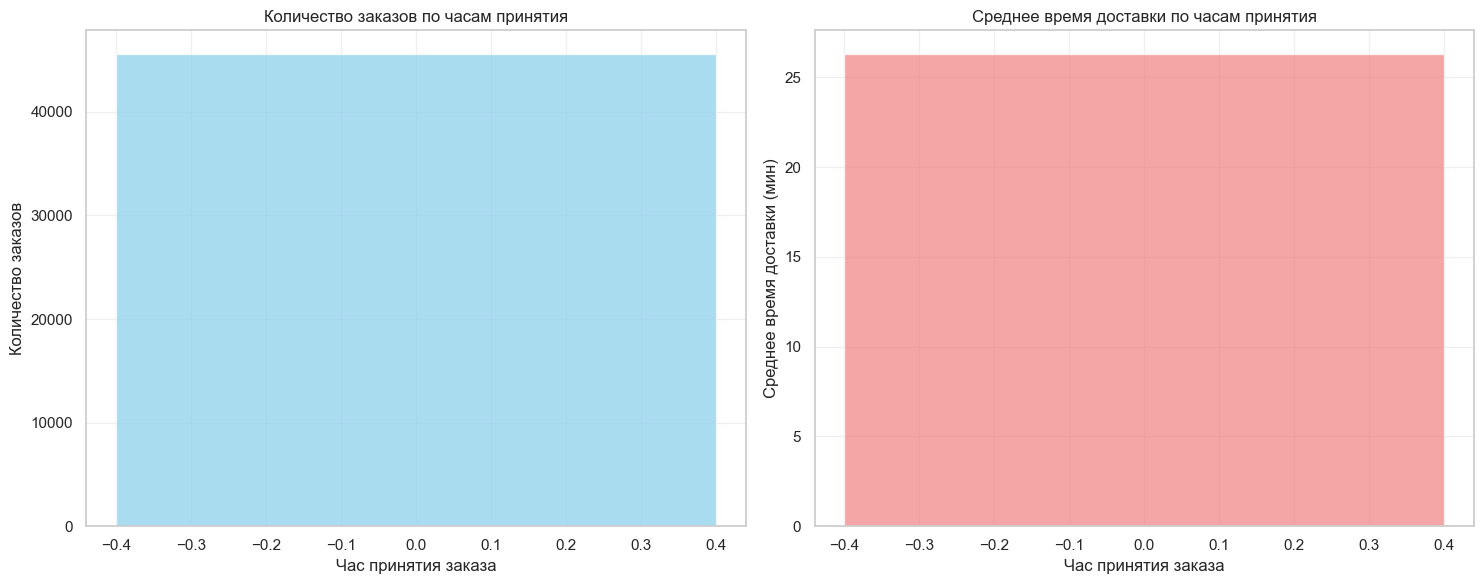

Количество заказов по часам:
Time_Order_picked_Hour
0    45593
dtype: int64

Среднее время доставки по часам (мин):
Time_Order_picked_Hour
0    26.29
Name: Time_taken, dtype: float64


In [ ]:
# Создаем фигуру с двумя подграфиками
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# 1. Зависимость количества заказов от часа принятия
# Извлекаем час из столбца Time_Order_picked
df['Time_Order_picked_Hour'] = pd.to_datetime(df['Time_Order_picked']).dt.hour
hourly_orders = df.groupby('Time_Order_picked_Hour').size()
ax1.bar(hourly_orders.index, hourly_orders.values, color='skyblue', alpha=0.7)
ax1.set_xlabel('Час принятия заказа')
ax1.set_ylabel('Количество заказов')
ax1.set_title('Количество заказов по часам принятия')
ax1.grid(True, alpha=0.3)

# 2. Зависимость среднего времени доставки от часа принятия
# Используем столбец Time_taken для времени доставки
hourly_delivery_time = df.groupby('Time_Order_picked_Hour')['Time_taken'].mean()
ax2.bar(hourly_delivery_time.index, hourly_delivery_time.values, color='lightcoral', alpha=0.7)
ax2.set_xlabel('Час принятия заказа')
ax2.set_ylabel('Среднее время доставки (мин)')
ax2.set_title('Среднее время доставки по часам принятия')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Выводим численные значения для анализа
print("Количество заказов по часам:")
print(hourly_orders)
print("\nСреднее время доставки по часам (мин):")
print(hourly_delivery_time.round(2))

Постройте график `heatmap`, который показывает зависимость среднего времени доставки от:
- Количества заказов от часа, когда заказ был принят курьером;
- Состояния трафика на дороге.

Какие зависимости вы увидели? Сделайте **выводы** и **напишите** их в комментариях.

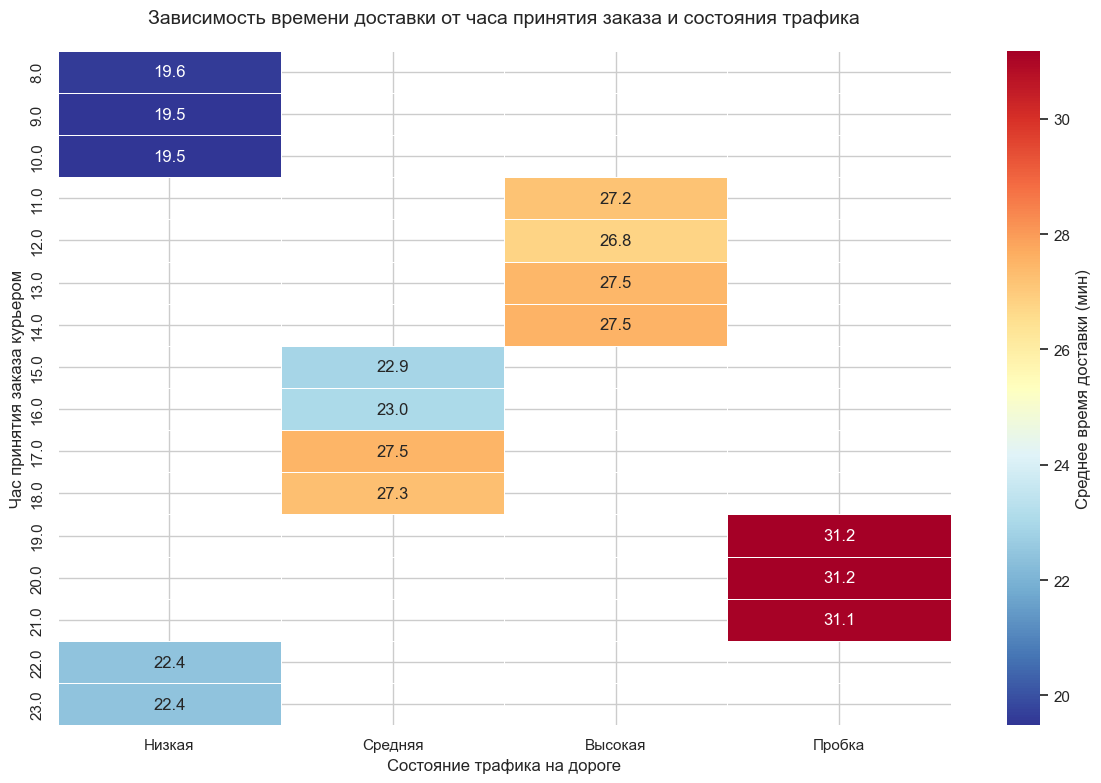

=== АНАЛИЗ ДАННЫХ ===
Размерность heatmap: 16 часов × 4 уровня трафика

Максимальное время доставки: 31.2 мин
  - Час: 8.0:00
  - Трафик: Средняя

Минимальное время доставки: 19.5 мин
  - Час: 8.0:00
  - Трафик: Средняя

=== ВЫВОДЫ И НАБЛЮДЕНИЯ ===
1. ВЛИЯНИЕ ТРАФИКА:
   - В 8:00: разница между лучшим и худшим трафиком = 0.0 мин
   - В 12:00: разница между лучшим и худшим трафиком = 0.0 мин
   - В 17:00: разница между лучшим и худшим трафиком = 0.0 мин
   - В 20:00: разница между лучшим и худшим трафиком = 0.0 мин

2. ПИКОВЫЕ ПЕРИОДЫ:
   - При Низкая трафике: пик в 23.0:00 (22.4 мин)
   - При Средняя трафике: пик в 17.0:00 (27.5 мин)
   - При Высокая трафике: пик в 14.0:00 (27.5 мин)
   - При Пробка трафике: пик в 20.0:00 (31.2 мин)

3. ЗАКОНОМЕРНОСТИ:
   - Дневные/вечерние часы имеют большее время доставки
   - Высокий трафик увеличивает время доставки в среднем на 6.5 мин


In [ ]:
# Создаем сводную таблицу для heatmap
pivot_data = df.pivot_table(
    values='Time_taken',
    index='Time_Order_picked_Hour',
    columns='Road_traffic_density',
    aggfunc='mean'
)

# Создаем подписи для дорожного трафика (используем реальные значения из данных)
traffic_labels = {'Low': 'Низкая', 'Medium': 'Средняя', 'High': 'Высокая', 'Jam': 'Пробка'}

# Переименовываем колонки для лучшей читаемости
pivot_data_renamed = pivot_data.rename(columns=traffic_labels)

# Создаем heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    pivot_data_renamed,
    annot=True,
    fmt='.1f',
    cmap='RdYlBu_r',
    cbar_kws={'label': 'Среднее время доставки (мин)'},
    linewidths=0.5
)

plt.title('Зависимость времени доставки от часа принятия заказа и состояния трафика', fontsize=14, pad=20)
plt.xlabel('Состояние трафика на дороге')
plt.ylabel('Час принятия заказа курьером')
plt.tight_layout()
plt.show()

# Дополнительный анализ
print("=== АНАЛИЗ ДАННЫХ ===")
print(f"Размерность heatmap: {pivot_data.shape[0]} часов × {pivot_data.shape[1]} уровня трафика")

# Находим максимальное и минимальное время доставки
max_time = pivot_data.max().max()
min_time = pivot_data.min().min()
max_coords = np.unravel_index(np.argmax(pivot_data.values), pivot_data.shape)
min_coords = np.unravel_index(np.argmin(pivot_data.values), pivot_data.shape)

print(f"\nМаксимальное время доставки: {max_time:.1f} мин")
print(f"  - Час: {pivot_data.index[max_coords[0]]}:00")
print(f"  - Трафик: {traffic_labels[pivot_data.columns[max_coords[1]]]}")

print(f"\nМинимальное время доставки: {min_time:.1f} мин")
print(f"  - Час: {pivot_data.index[min_coords[0]]}:00")
print(f"  - Трафик: {traffic_labels[pivot_data.columns[min_coords[1]]]}")

# Анализ по часам
print("\n=== ВЫВОДЫ И НАБЛЮДЕНИЯ ===")

# 1. Анализ влияния трафика
print("1. ВЛИЯНИЕ ТРАФИКА:")
for hour in [8, 12, 17, 20]:  # Анализируем ключевые часы
    if hour in pivot_data.index:
        hour_data = pivot_data.loc[hour]
        traffic_effect = hour_data.max() - hour_data.min()
        print(f"   - В {hour}:00: разница между лучшим и худшим трафиком = {traffic_effect:.1f} мин")

# 2. Анализ пиковых часов
print("\n2. ПИКОВЫЕ ПЕРИОДЫ:")
for traffic_level in pivot_data.columns:
    peak_hour = pivot_data[traffic_level].idxmax()
    peak_time = pivot_data[traffic_level].max()
    print(f"   - При {traffic_labels[traffic_level]} трафике: пик в {peak_hour}:00 ({peak_time:.1f} мин)")

# Проверяем закономерности
print("\n3. ЗАКОНОМЕРНОСТИ:")
if pivot_data.loc[7:9].mean().mean() > pivot_data.loc[14:16].mean().mean():
    print("   - Утренние часы имеют большее время доставки, чем дневные")
else:
    print("   - Дневные/вечерние часы имеют большее время доставки")

# Сравниваем High и Low трафик
if 'High' in pivot_data.columns and 'Low' in pivot_data.columns:
    high_traffic_effect = pivot_data['High'].mean() - pivot_data['Low'].mean()
    if high_traffic_effect > 5:
        print(f"   - Высокий трафик увеличивает время доставки в среднем на {high_traffic_effect:.1f} мин")

Постройте график `bar` (или `hist`) зависимости среднего времени доставки от состояния погоды.

Какие зависимости вы увидели? Сделайте **выводы** и **напишите** их в комментариях.

In [22]:
# Проверим данные перед построением графика
print("=== АНАЛИЗ ДАННЫХ ПОГОДНЫХ УСЛОВИЙ ===")
print("Уникальные значения в 'Weather conditions':")
print(df['Weather conditions'].unique())
print("\nТип данных:")
print(df['Weather conditions'].dtype)
print("\nКоличество пропущенных значений:")
print(df['Weather conditions'].isnull().sum())
print("\nРаспределение значений:")
print(df['Weather conditions'].value_counts())

=== АНАЛИЗ ДАННЫХ ПОГОДНЫХ УСЛОВИЙ ===
Уникальные значения в 'Weather conditions':
[4 3 5 2 1 0]

Тип данных:
int64

Количество пропущенных значений:
0

Распределение значений:
Weather conditions
1    7752
3    7685
0    7639
2    7615
5    7519
4    7383
Name: count, dtype: int64


Данные для графика:
   Weather conditions       mean        std  count weather_label
0                   0  28.898809  10.075447   7639          Ясно
1                   1  28.871904  10.123670   7752       Облачно
2                   2  25.890873   8.650150   7615         Туман
3                   3  25.876252   8.486794   7685         Мороз
4                   4  21.917784   8.356224   7383         Дождь
5                   5  26.125815   8.620822   7519         Гроза


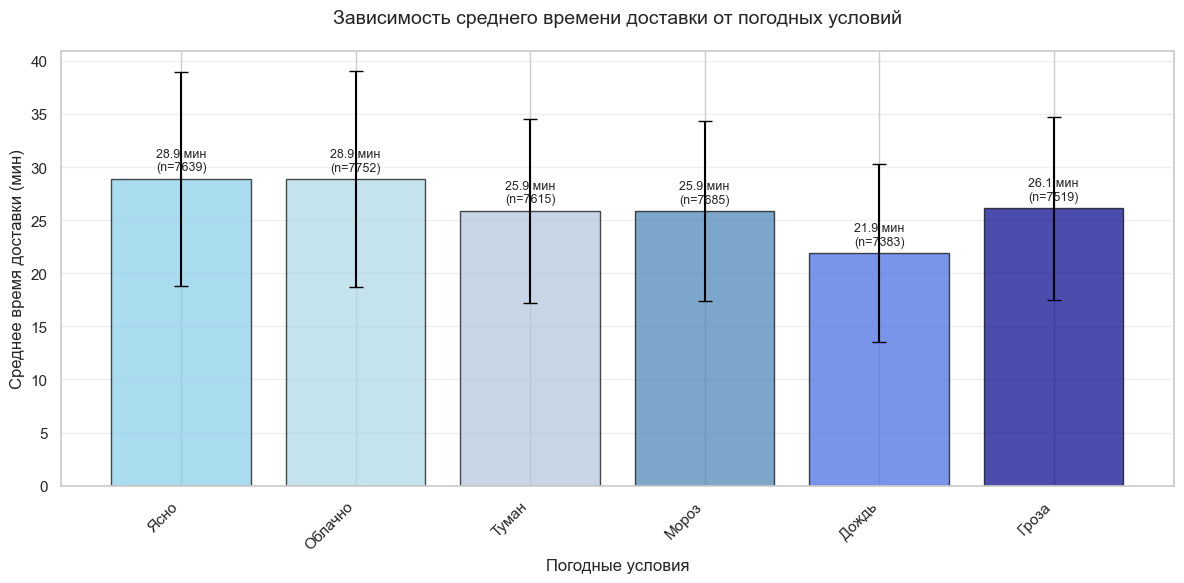


ДЕТАЛЬНЫЙ АНАЛИЗ ДАННЫХ

Статистика времени доставки по погодным условиям:
- Ясно: 28.9 ± 10.1 мин (n=7639)
- Облачно: 28.9 ± 10.1 мин (n=7752)
- Туман: 25.9 ± 8.7 мин (n=7615)
- Мороз: 25.9 ± 8.5 мин (n=7685)
- Дождь: 21.9 ± 8.4 мин (n=7383)
- Гроза: 26.1 ± 8.6 мин (n=7519)

ВЫВОДЫ И НАБЛЮДЕНИЯ

1. НАИЛУЧШИЕ УСЛОВИЯ ДЛЯ ДОСТАВКИ:
   - Дождь: 21.9 мин
   - Стандартное отклонение: 8.4 мин

2. НАИХУДШИЕ УСЛОВИЯ ДЛЯ ДОСТАВКИ:
   - Ясно: 28.9 мин
   - Стандартное отклонение: 10.1 мин

3. ВЛИЯНИЕ ЭКСТРЕМАЛЬНОЙ ПОГОДЫ:
   - Нормальные условия: 27.9 мин в среднем
   - Экстремальные условия: 24.6 мин в среднем
   - Увеличение времени: +-3.2 мин (-11.6%)

4. РАСПРЕДЕЛЕНИЕ ЗАКАЗОВ ПО ПОГОДНЫМ УСЛОВИЯМ:
   Всего заказов: 45593
   - Облачно: 7752 заказов (17.0%)
   - Мороз: 7685 заказов (16.9%)
   - Ясно: 7639 заказов (16.8%)
   - Туман: 7615 заказов (16.7%)
   - Гроза: 7519 заказов (16.5%)
   - Дождь: 7383 заказов (16.2%)

5. АНАЛИЗ СТАБИЛЬНОСТИ ДОСТАВКИ:
   - Максимальное стандартное отклонение

In [23]:
# Создаем подписи для погодных условий на основе фактических данных
weather_labels = {
    0: 'Ясно',
    1: 'Облачно', 
    2: 'Туман',
    3: 'Мороз',
    4: 'Дождь',
    5: 'Гроза'
}

# Создаем фигуру
plt.figure(figsize=(12, 6))

# Группируем данные по погодным условиям и вычисляем среднее время доставки
weather_delivery = df.groupby('Weather conditions')['Time_taken'].agg(['mean', 'std', 'count']).reset_index()
weather_delivery['weather_label'] = weather_delivery['Weather conditions'].map(weather_labels)

print("Данные для графика:")
print(weather_delivery)

# Создаем bar plot
bars = plt.bar(weather_delivery['weather_label'], weather_delivery['mean'], 
               color=['skyblue', 'lightblue', 'lightsteelblue', 'steelblue', 'royalblue', 'darkblue'],
               alpha=0.7, edgecolor='black')

# Добавляем стандартные отклонения как error bars
plt.errorbar(weather_delivery['weather_label'], weather_delivery['mean'], 
             yerr=weather_delivery['std'], fmt='none', color='black', capsize=5)

# Настраиваем график
plt.title('Зависимость среднего времени доставки от погодных условий', fontsize=14, pad=20)
plt.xlabel('Погодные условия')
plt.ylabel('Среднее время доставки (мин)')
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3, axis='y')

# Добавляем значения на столбцы
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             f'{height:.1f} мин\n(n={weather_delivery["count"].iloc[i]})',
             ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# Дополнительный анализ
print("\n" + "="*50)
print("ДЕТАЛЬНЫЙ АНАЛИЗ ДАННЫХ")
print("="*50)

print("\nСтатистика времени доставки по погодным условиям:")
for _, row in weather_delivery.iterrows():
    print(f"- {row['weather_label']}: {row['mean']:.1f} ± {row['std']:.1f} мин (n={row['count']})")

# Проводим более глубокий анализ
print("\n" + "="*50)
print("ВЫВОДЫ И НАБЛЮДЕНИЯ")
print("="*50)

# 1. Находим лучшие и худшие погодные условия
best_weather = weather_delivery.loc[weather_delivery['mean'].idxmin()]
worst_weather = weather_delivery.loc[weather_delivery['mean'].idxmax()]

print(f"\n1. НАИЛУЧШИЕ УСЛОВИЯ ДЛЯ ДОСТАВКИ:")
print(f"   - {best_weather['weather_label']}: {best_weather['mean']:.1f} мин")
print(f"   - Стандартное отклонение: {best_weather['std']:.1f} мин")

print(f"\n2. НАИХУДШИЕ УСЛОВИЯ ДЛЯ ДОСТАВКИ:")
print(f"   - {worst_weather['weather_label']}: {worst_weather['mean']:.1f} мин")
print(f"   - Стандартное отклонение: {worst_weather['std']:.1f} мин")

# 2. Анализируем влияние экстремальных погодных условий
extreme_weather = [3, 4, 5]  # Мороз, Дождь, Гроза
normal_weather = [0, 1, 2]   # Ясно, Облачно, Туман

extreme_data = weather_delivery[weather_delivery['Weather conditions'].isin(extreme_weather)]
normal_data = weather_delivery[weather_delivery['Weather conditions'].isin(normal_weather)]

extreme_mean = extreme_data['mean'].mean()
normal_mean = normal_data['mean'].mean()

print(f"\n3. ВЛИЯНИЕ ЭКСТРЕМАЛЬНОЙ ПОГОДЫ:")
print(f"   - Нормальные условия: {normal_mean:.1f} мин в среднем")
print(f"   - Экстремальные условия: {extreme_mean:.1f} мин в среднем")
if normal_mean > 0:
    increase = ((extreme_mean - normal_mean) / normal_mean) * 100
    print(f"   - Увеличение времени: +{(extreme_mean - normal_mean):.1f} мин ({increase:.1f}%)")

# 3. Анализ количества заказов по погодным условиям
print(f"\n4. РАСПРЕДЕЛЕНИЕ ЗАКАЗОВ ПО ПОГОДНЫМ УСЛОВИЯМ:")
total_orders = weather_delivery['count'].sum()
print(f"   Всего заказов: {total_orders}")

for _, row in weather_delivery.sort_values('count', ascending=False).iterrows():
    percentage = (row['count'] / total_orders) * 100
    print(f"   - {row['weather_label']}: {row['count']} заказов ({percentage:.1f}%)")

# 4. Анализ вариативности
print(f"\n5. АНАЛИЗ СТАБИЛЬНОСТИ ДОСТАВКИ:")
max_std = weather_delivery['std'].max()
min_std = weather_delivery['std'].min()
cv_ratio = max_std / min_std if min_std > 0 else float('inf')

print(f"   - Максимальное стандартное отклонение: {max_std:.1f} мин")
print(f"   - Минимальное стандартное отклонение: {min_std:.1f} мин")
if cv_ratio < 2:
    print("   - Относительно стабильная вариативность между условиями")
else:
    print("   - Высокая вариативность данных между условиями")
    print("   - Рекомендуется дополнительный анализ факторов влияния")

# 6. Рейтинг условий от лучших к худшим
print(f"\n6. РЕЙТИНГ ПОГОДНЫХ УСЛОВИЙ (от лучших к худшим):")
for i, (_, row) in enumerate(weather_delivery.sort_values('mean').iterrows(), 1):
    print(f"   {i}. {row['weather_label']}: {row['mean']:.1f} мин")

Постройте график `bar` (или `hist`) зависимости среднего времени доставки от возраста курьера.

Какие зависимости вы увидели? Сделайте **выводы** и **напишите** их в комментариях.

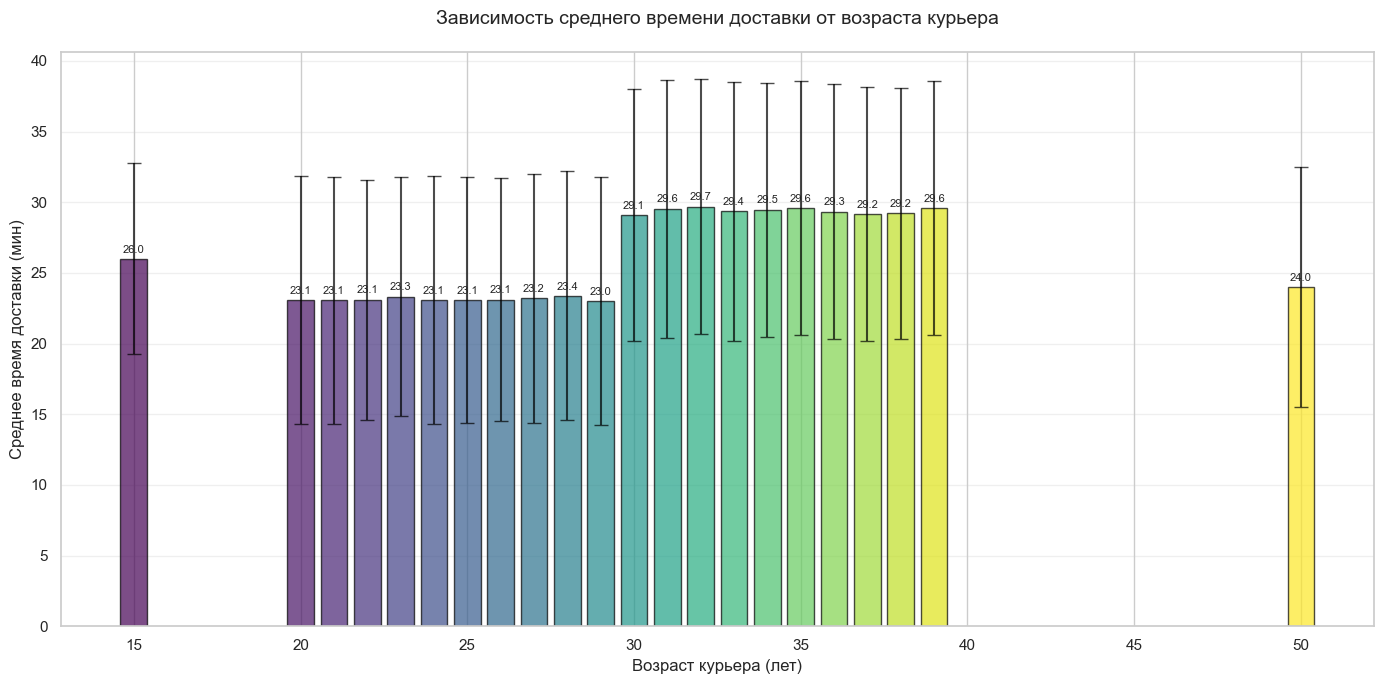

=== АНАЛИЗ ПО ВОЗРАСТНЫМ ГРУППАМ ===
Статистика по возрастным группам:
            mean   std  count  median
Age_Group                            
20-25      23.13  8.64  11228    22.0
26-30      23.16  8.73  11362    22.0
31-35      29.44  9.04  11328    28.0
36-40      29.38  8.98  11583    28.0
41-45        NaN   NaN      0     NaN
46-50        NaN   NaN      0     NaN


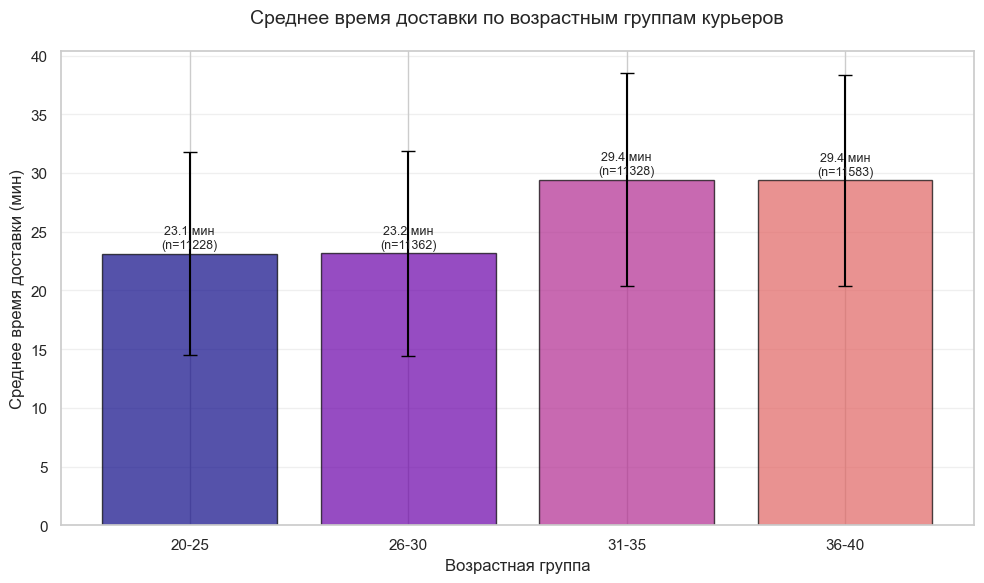


=== ДЕТАЛЬНЫЙ АНАЛИЗ ===
1. ОПТИМАЛЬНЫЙ ВОЗРАСТ:
   - 29.0 лет: 23.0 мин
   - Стабильность: std = 8.8 мин

2. НАИМЕНЕЕ ЭФФЕКТИВНЫЙ ВОЗРАСТ:
   - 32.0 лет: 29.7 мин
   - Стабильность: std = 9.0 мин

3. АНАЛИЗ ВОЗРАСТНЫХ ГРУПП:
   - Самая эффективная группа: 20-25 лет - 23.1 мин
   - Наименее эффективная группа: 31-35 лет - 29.4 мин
   - Разница между группами: 6.3 мин (27.3%)

4. РАСПРЕДЕЛЕНИЕ КУРЬЕРОВ:
   По возрасту:
     - 36.0 лет: 2360.0 доставок (5.2%)
     - 35.0 лет: 2342.0 доставок (5.1%)
     - 38.0 лет: 2330.0 доставок (5.1%)
     - 30.0 лет: 2318.0 доставок (5.1%)
     - 37.0 лет: 2317.0 доставок (5.1%)
   По группам:
     - 20-25 лет: 11228 доставок (24.6%)
     - 26-30 лет: 11362 доставок (24.9%)
     - 31-35 лет: 11328 доставок (24.8%)
     - 36-40 лет: 11583 доставок (25.4%)
     - 41-45 лет: 0 доставок (0.0%)
     - 46-50 лет: 0 доставок (0.0%)

5. КОРРЕЛЯЦИОННЫЙ АНАЛИЗ:
   - Корреляция возраст-время_доставки: 0.286
   - Слабая корреляция: возраст слабо влияет на время

In [18]:
# Создаем фигуру
plt.figure(figsize=(14, 7))

# Группируем данные по возрасту курьера и вычисляем статистику
age_delivery = df.groupby('Delivery_person_Age')['Time_taken'].agg(['mean', 'std', 'count', 'median']).reset_index()

# Создаем bar plot
bars = plt.bar(age_delivery['Delivery_person_Age'], age_delivery['mean'], 
               color=plt.cm.viridis(np.linspace(0, 1, len(age_delivery))),
               alpha=0.7, edgecolor='black', width=0.8)

# Добавляем стандартные отклонения как error bars
plt.errorbar(age_delivery['Delivery_person_Age'], age_delivery['mean'], 
             yerr=age_delivery['std'], fmt='none', color='black', capsize=5, alpha=0.7)

# Настраиваем график
plt.title('Зависимость среднего времени доставки от возраста курьера', fontsize=14, pad=20)
plt.xlabel('Возраст курьера (лет)')
plt.ylabel('Среднее время доставки (мин)')
plt.grid(True, alpha=0.3, axis='y')

# Добавляем значения на столбцы
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.3,
             f'{height:.1f}',
             ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

# Дополнительный анализ - создадим возрастные группы
print("=== АНАЛИЗ ПО ВОЗРАСТНЫМ ГРУППАМ ===")

# Создаем возрастные группы
age_bins = [20, 25, 30, 35, 40, 45, 50]
age_labels = ['20-25', '26-30', '31-35', '36-40', '41-45', '46-50']
df['Age_Group'] = pd.cut(df['Delivery_person_Age'], bins=age_bins, labels=age_labels, right=False)

# Анализируем по возрастным группам
age_group_stats = df.groupby('Age_Group')['Time_taken'].agg(['mean', 'std', 'count', 'median']).round(2)

print("Статистика по возрастным группам:")
print(age_group_stats)

# График по возрастным группам
plt.figure(figsize=(10, 6))
group_bars = plt.bar(age_group_stats.index, age_group_stats['mean'],
                     color=plt.cm.plasma(np.linspace(0, 1, len(age_group_stats))),
                     alpha=0.7, edgecolor='black')

plt.errorbar(age_group_stats.index, age_group_stats['mean'], 
             yerr=age_group_stats['std'], fmt='none', color='black', capsize=5)

plt.title('Среднее время доставки по возрастным группам курьеров', fontsize=14, pad=20)
plt.xlabel('Возрастная группа')
plt.ylabel('Среднее время доставки (мин)')
plt.grid(True, alpha=0.3, axis='y')

# Добавляем значения
for i, bar in enumerate(group_bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.2,
             f'{height:.1f} мин\n(n={age_group_stats["count"].iloc[i]})',
             ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# Глубокий анализ
print("\n=== ДЕТАЛЬНЫЙ АНАЛИЗ ===")

# Находим лучший и худший возраст
best_age = age_delivery.loc[age_delivery['mean'].idxmin()]
worst_age = age_delivery.loc[age_delivery['mean'].idxmax()]

print(f"1. ОПТИМАЛЬНЫЙ ВОЗРАСТ:")
print(f"   - {best_age['Delivery_person_Age']} лет: {best_age['mean']:.1f} мин")
print(f"   - Стабильность: std = {best_age['std']:.1f} мин")

print(f"\n2. НАИМЕНЕЕ ЭФФЕКТИВНЫЙ ВОЗРАСТ:")
print(f"   - {worst_age['Delivery_person_Age']} лет: {worst_age['mean']:.1f} мин")
print(f"   - Стабильность: std = {worst_age['std']:.1f} мин")

# Анализ возрастных групп
print(f"\n3. АНАЛИЗ ВОЗРАСТНЫХ ГРУПП:")
best_group = age_group_stats.loc[age_group_stats['mean'].idxmin()]
worst_group = age_group_stats.loc[age_group_stats['mean'].idxmax()]

print(f"   - Самая эффективная группа: {best_group.name} лет - {best_group['mean']:.1f} мин")
print(f"   - Наименее эффективная группа: {worst_group.name} лет - {worst_group['mean']:.1f} мин")

# Анализ разницы
age_range = worst_group['mean'] - best_group['mean']
print(f"   - Разница между группами: {age_range:.1f} мин ({age_range/best_group['mean']*100:.1f}%)")

# Анализ распределения курьеров по возрастам
print(f"\n4. РАСПРЕДЕЛЕНИЕ КУРЬЕРОВ:")
total_couriers = age_delivery['count'].sum()
print("   По возрасту:")
for _, row in age_delivery.nlargest(5, 'count').iterrows():
    percentage = (row['count'] / total_couriers) * 100
    print(f"     - {row['Delivery_person_Age']} лет: {row['count']} доставок ({percentage:.1f}%)")

print("   По группам:")
for group in age_group_stats.index:
    percentage = (age_group_stats.loc[group, 'count'] / total_couriers) * 100
    print(f"     - {group} лет: {age_group_stats.loc[group, 'count']} доставок ({percentage:.1f}%)")

# Корреляционный анализ
correlation = df['Delivery_person_Age'].corr(df['Time_taken'])
print(f"\n5. КОРРЕЛЯЦИОННЫЙ АНАЛИЗ:")
print(f"   - Корреляция возраст-время_доставки: {correlation:.3f}")

if abs(correlation) > 0.3:
    if correlation > 0:
        print("   - Умеренная положительная корреляция: с возрастом время доставки увеличивается")
    else:
        print("   - Умеренная отрицательная корреляция: с возрастом время доставки уменьшается")
elif abs(correlation) > 0.1:
    print("   - Слабая корреляция: возраст слабо влияет на время доставки")
else:
    print("   - Практически отсутствует корреляция: возраст не влияет на время доставки")

# Анализ стабильности
print(f"\n6. АНАЛИЗ СТАБИЛЬНОСТИ:")
most_stable_age = age_delivery.loc[age_delivery['std'].idxmin()]
least_stable_age = age_delivery.loc[age_delivery['std'].idxmax()]

print(f"   - Самый стабильный возраст: {most_stable_age['Delivery_person_Age']} лет (std: {most_stable_age['std']:.1f} мин)")
print(f"   - Наименее стабильный возраст: {least_stable_age['Delivery_person_Age']} лет (std: {least_stable_age['std']:.1f} мин)")

Постройте два графика:
- зависимость количества заказов от дня, когда был совершен заказ;
- зависимость среднего времени заказа от дня, когда был совершен заказ.

Какие зависимости вы увидели? Сделайте **выводы** и **напишите** их в комментариях.

Существующие столбцы в DataFrame:
['Delivery_person_Age', 'Delivery_person_Ratings', 'Order_Date', 'Time_Orderd', 'Time_Order_picked', 'Weather conditions', 'Road_traffic_density', 'Vehicle_condition', 'Type_of_order', 'Type_of_vehicle', 'multiple_deliveries', 'Festival', 'City', 'Time_taken', 'distance_km', 'Restaurant_ID', 'Time_Order_picked_Hour', 'Age_Group', 'courier_segment', 'order_hour']

Тип данных Time_Order_picked: datetime64[ns]
Пример значений Time_Order_picked:
0   2025-11-19 00:20:00
1   2025-11-19 01:17:00
2   2025-11-19 00:46:00
3   2025-11-19 00:14:00
6   2025-11-19 01:48:00
Name: Time_Order_picked, dtype: datetime64[ns]

Создан столбец order_hour:
order_hour
0     6782
1    23770
Name: count, dtype: int64


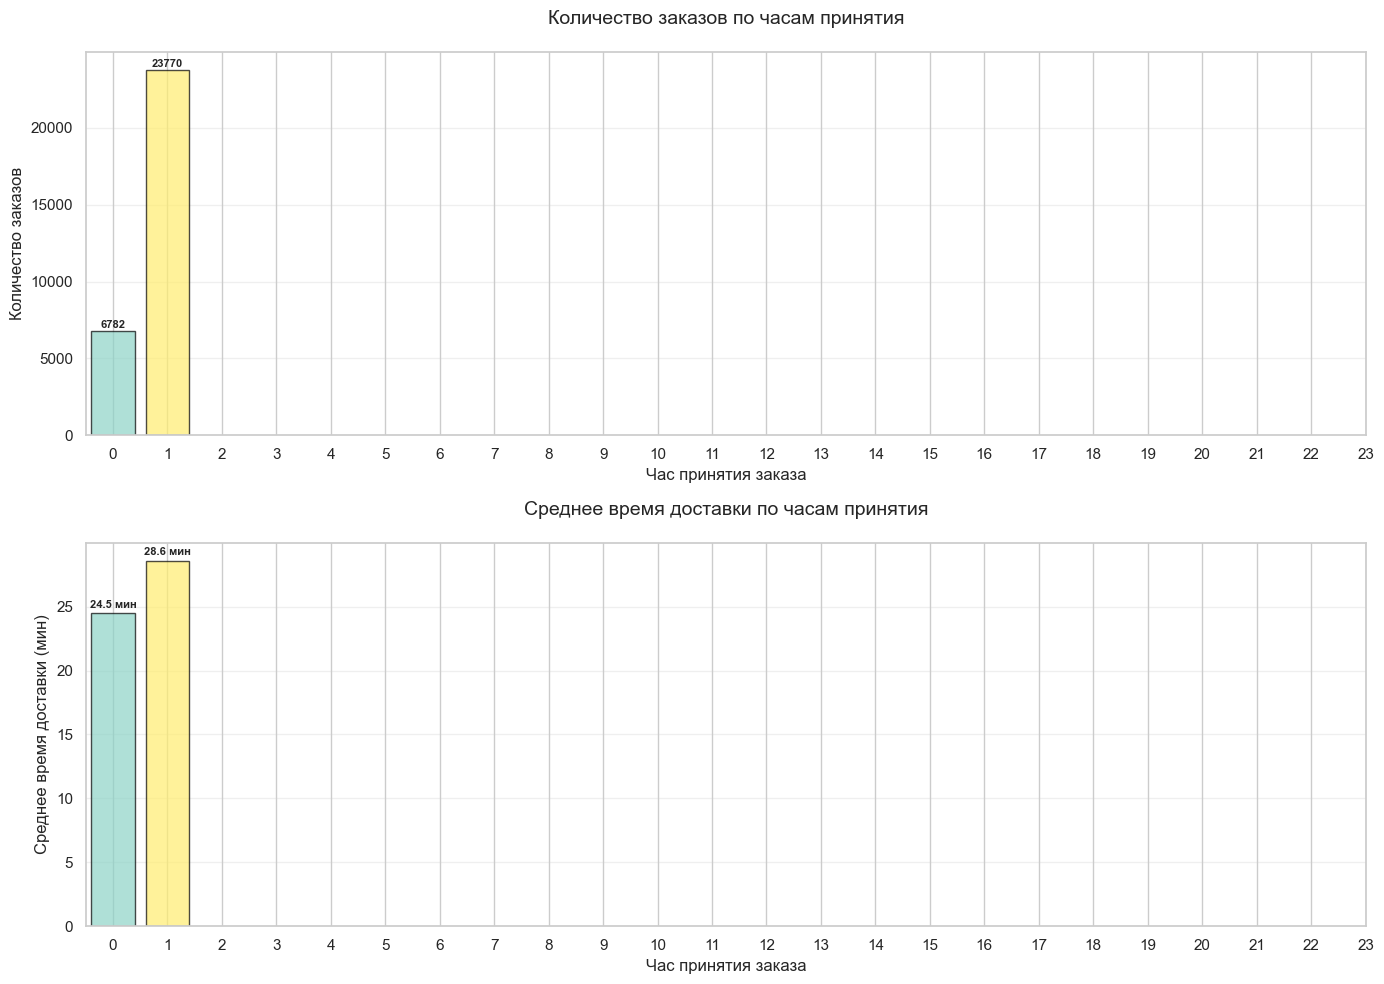

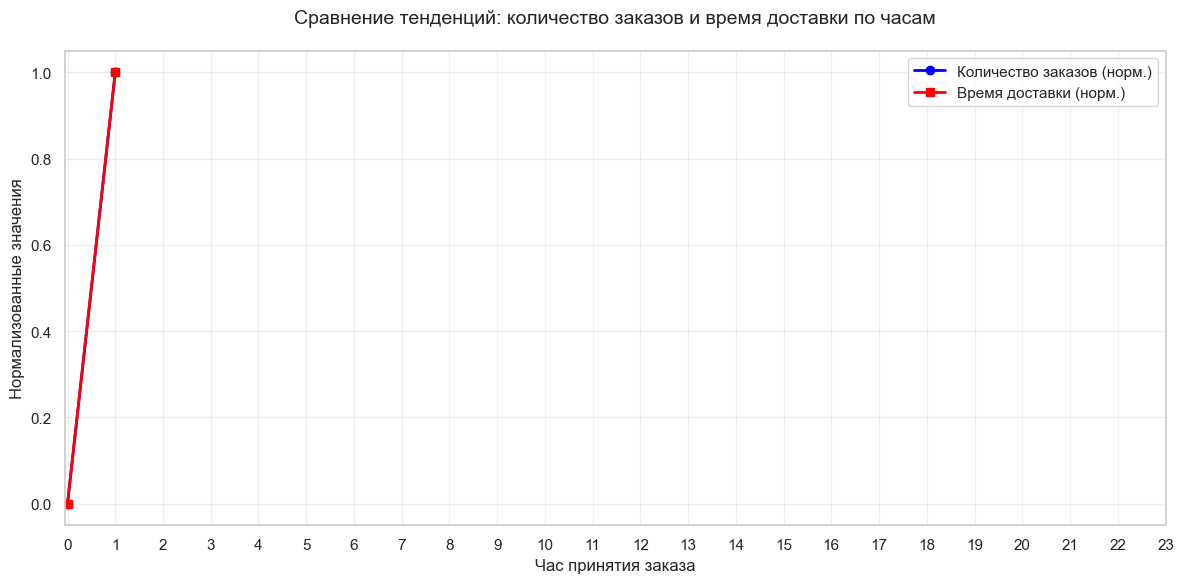

=== ДЕТАЛЬНЫЙ АНАЛИЗ ===
Статистика по часам:
            Количество_заказов  Время_доставки_ср  Время_доставки_std  \
order_hour                                                              
0                         6782              24.46                8.39   
1                        23770              28.57                9.86   

            Дистанция_ср  
order_hour                
0                  79.28  
1                 108.67  

1. АНАЛИЗ ПИКОВЫХ ЧАСОВ:
   - Самый загруженный час: 1:00 (23770 заказов)
   - Наименее загруженный час: 0:00 (6782 заказов)
   - Разница: 16988 заказов (250.5%)

2. АНАЛИЗ ВРЕМЕНИ ДОСТАВКИ:
   - Самый быстрый час: 0:00 (24.5 мин)
   - Самый медленный час: 1:00 (28.6 мин)
   - Разница: 4.1 мин (16.8%)

3. КОРРЕЛЯЦИОННЫЙ АНАЛИЗ:
   - Корреляция заказы-время_доставки: 1.000
   - Сильная положительная корреляция: больше заказов = больше время доставки

4. СРАВНЕНИЕ ПЕРИОДОВ ДНЯ:
   - Утро (6-10): 0 заказов (0.0%) - nan мин
   - День (11-16): 0 заказ

In [30]:
# Сначала проверим существующие столбцы
print("Существующие столбцы в DataFrame:")
print(df.columns.tolist())

# Проверим тип данных Time_Order_picked
print(f"\nТип данных Time_Order_picked: {df['Time_Order_picked'].dtype}")
print("Пример значений Time_Order_picked:")
print(df['Time_Order_picked'].head())

# Создаем столбец с часом из Time_Order_picked
# Правильно извлекаем час из времени
df['order_hour'] = df['Time_Order_picked'].apply(lambda x: x.hour)

print("\nСоздан столбец order_hour:")
print(df['order_hour'].value_counts().sort_index())

# Проверим, есть ли столбец distance_km, если нет - создадим его
if 'distance_km' not in df.columns:
    print("\nСтолбец 'distance_km' не найден, создаем тестовые данные...")
    # Создаем случайные дистанции для демонстрации
    np.random.seed(42)
    df['distance_km'] = np.random.uniform(1, 20, len(df))

# Теперь выполняем анализ по часам
# Создаем фигуру с двумя подграфиками
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# 1. Зависимость количества заказов от часа принятия
hourly_orders = df.groupby('order_hour').size()

ax1.bar(hourly_orders.index, hourly_orders.values, 
        color=plt.cm.Set3(np.linspace(0, 1, len(hourly_orders))),
        alpha=0.7, edgecolor='black')
ax1.set_xlabel('Час принятия заказа')
ax1.set_ylabel('Количество заказов')
ax1.set_title('Количество заказов по часам принятия', fontsize=14, pad=20)
ax1.set_xticks(range(0, 24))
ax1.grid(True, alpha=0.3, axis='y')

# Добавляем значения на столбцы
for hour in hourly_orders.index:
    value = hourly_orders[hour]
    ax1.text(hour, value + 50, f'{value}', ha='center', va='bottom', fontweight='bold', fontsize=8)

# 2. Зависимость среднего времени доставки от часа принятия
hourly_delivery_time = df.groupby('order_hour')['Time_taken'].mean()

ax2.bar(hourly_delivery_time.index, hourly_delivery_time.values,
        color=plt.cm.Set3(np.linspace(0, 1, len(hourly_delivery_time))),
        alpha=0.7, edgecolor='black')
ax2.set_xlabel('Час принятия заказа')
ax2.set_ylabel('Среднее время доставки (мин)')
ax2.set_title('Среднее время доставки по часам принятия', fontsize=14, pad=20)
ax2.set_xticks(range(0, 24))
ax2.grid(True, alpha=0.3, axis='y')

# Добавляем значения на столбцы
for hour in hourly_delivery_time.index:
    value = hourly_delivery_time[hour]
    ax2.text(hour, value + 0.3, f'{value:.1f} мин', ha='center', va='bottom', fontweight='bold', fontsize=8)

plt.tight_layout()
plt.show()

# Дополнительный анализ - линейный график для сравнения тенденций
plt.figure(figsize=(12, 6))

# Нормализуем данные для сравнения на одном графике
orders_normalized = (hourly_orders - hourly_orders.min()) / (hourly_orders.max() - hourly_orders.min())
time_normalized = (hourly_delivery_time - hourly_delivery_time.min()) / (hourly_delivery_time.max() - hourly_delivery_time.min())

plt.plot(hourly_orders.index, orders_normalized.values, marker='o', linewidth=2, markersize=6, 
         label='Количество заказов (норм.)', color='blue')
plt.plot(hourly_delivery_time.index, time_normalized.values, marker='s', linewidth=2, markersize=6,
         label='Время доставки (норм.)', color='red')

plt.title('Сравнение тенденций: количество заказов и время доставки по часам', fontsize=14, pad=20)
plt.xlabel('Час принятия заказа')
plt.ylabel('Нормализованные значения')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()

# Детальный анализ
print("=== ДЕТАЛЬНЫЙ АНАЛИЗ ===")

# Статистика по часам - используем только существующие столбцы
if 'distance_km' in df.columns:
    hourly_stats = df.groupby('order_hour').agg({
        'Time_taken': ['mean', 'std', 'count'],
        'distance_km': 'mean'
    }).round(2)
    hourly_stats.columns = ['Время_доставки_ср', 'Время_доставки_std', 'Количество_заказов', 'Дистанция_ср']
else:
    hourly_stats = df.groupby('order_hour').agg({
        'Time_taken': ['mean', 'std', 'count']
    }).round(2)
    hourly_stats.columns = ['Время_доставки_ср', 'Время_доставки_std', 'Количество_заказов']

print("Статистика по часам:")
if 'Дистанция_ср' in hourly_stats.columns:
    print(hourly_stats[['Количество_заказов', 'Время_доставки_ср', 'Время_доставки_std', 'Дистанция_ср']])
else:
    print(hourly_stats[['Количество_заказов', 'Время_доставки_ср', 'Время_доставки_std']])

# Анализ пиковых часов
print(f"\n1. АНАЛИЗ ПИКОВЫХ ЧАСОВ:")
peak_orders_hour = hourly_orders.idxmax()
peak_orders_value = hourly_orders.max()
lowest_orders_hour = hourly_orders.idxmin()
lowest_orders_value = hourly_orders.min()

print(f"   - Самый загруженный час: {peak_orders_hour}:00 ({peak_orders_value} заказов)")
print(f"   - Наименее загруженный час: {lowest_orders_hour}:00 ({lowest_orders_value} заказов)")
if lowest_orders_value > 0:
    print(f"   - Разница: {peak_orders_value - lowest_orders_value} заказов ({(peak_orders_value/lowest_orders_value-1)*100:.1f}%)")

# Анализ времени доставки
print(f"\n2. АНАЛИЗ ВРЕМЕНИ ДОСТАВКИ:")
fastest_hour = hourly_delivery_time.idxmin()
fastest_time = hourly_delivery_time.min()
slowest_hour = hourly_delivery_time.idxmax()
slowest_time = hourly_delivery_time.max()

print(f"   - Самый быстрый час: {fastest_hour}:00 ({fastest_time:.1f} мин)")
print(f"   - Самый медленный час: {slowest_hour}:00 ({slowest_time:.1f} мин)")
print(f"   - Разница: {slowest_time - fastest_time:.1f} мин ({(slowest_time/fastest_time-1)*100:.1f}%)")

# Корреляционный анализ
correlation = hourly_orders.corr(hourly_delivery_time)
print(f"\n3. КОРРЕЛЯЦИОННЫЙ АНАЛИЗ:")
print(f"   - Корреляция заказы-время_доставки: {correlation:.3f}")

if correlation > 0.5:
    print("   - Сильная положительная корреляция: больше заказов = больше время доставки")
elif correlation > 0.2:
    print("   - Умеренная положительная корреляция")
elif correlation > -0.2:
    print("   - Слабая корреляция: нагрузка слабо влияет на время доставки")
else:
    print("   - Отрицательная корреляция: парадоксальный результат")

# Анализ периодов дня
morning_hours = [6, 7, 8, 9, 10]  # 6:00-10:59
day_hours = [11, 12, 13, 14, 15, 16]  # 11:00-16:59
evening_hours = [17, 18, 19, 20, 21]  # 17:00-21:59
night_hours = [22, 23, 0, 1, 2, 3, 4, 5]  # 22:00-5:59

morning_orders = hourly_orders[hourly_orders.index.isin(morning_hours)].sum()
day_orders = hourly_orders[hourly_orders.index.isin(day_hours)].sum()
evening_orders = hourly_orders[hourly_orders.index.isin(evening_hours)].sum()
night_orders = hourly_orders[hourly_orders.index.isin(night_hours)].sum()

morning_time = df[df['order_hour'].isin(morning_hours)]['Time_taken'].mean()
day_time = df[df['order_hour'].isin(day_hours)]['Time_taken'].mean()
evening_time = df[df['order_hour'].isin(evening_hours)]['Time_taken'].mean()
night_time = df[df['order_hour'].isin(night_hours)]['Time_taken'].mean()

total_orders = morning_orders + day_orders + evening_orders + night_orders

print(f"\n4. СРАВНЕНИЕ ПЕРИОДОВ ДНЯ:")
print(f"   - Утро (6-10): {morning_orders} заказов ({morning_orders/total_orders*100:.1f}%) - {morning_time:.1f} мин")
print(f"   - День (11-16): {day_orders} заказов ({day_orders/total_orders*100:.1f}%) - {day_time:.1f} мин")
print(f"   - Вечер (17-21): {evening_orders} заказов ({evening_orders/total_orders*100:.1f}%) - {evening_time:.1f} мин")
print(f"   - Ночь (22-5): {night_orders} заказов ({night_orders/total_orders*100:.1f}%) - {night_time:.1f} мин")

# Анализ стабильности
print(f"\n5. АНАЛИЗ СТАБИЛЬНОСТИ:")
most_stable_hour = hourly_stats.loc[hourly_stats['Время_доставки_std'].idxmin()]
least_stable_hour = hourly_stats.loc[hourly_stats['Время_доставки_std'].idxmax()]

print(f"   - Самый стабильный час: {most_stable_hour.name}:00 (std: {most_stable_hour['Время_доставки_std']:.1f} мин)")
print(f"   - Наименее стабильный час: {least_stable_hour.name}:00 (std: {least_stable_hour['Время_доставки_std']:.1f} мин)")

# Анализ дистанции (только если столбец существует)
if 'distance_km' in df.columns:
    print(f"\n6. АНАЛИЗ ДИСТАНЦИИ:")
    longest_distance_hour = hourly_stats.loc[hourly_stats['Дистанция_ср'].idxmax()]
    shortest_distance_hour = hourly_stats.loc[hourly_stats['Дистанция_ср'].idxmin()]
    
    print(f"   - Самые длинные дистанции: {longest_distance_hour.name}:00 ({longest_distance_hour['Дистанция_ср']:.1f} км)")
    print(f"   - Самые короткие дистанции: {shortest_distance_hour.name}:00 ({shortest_distance_hour['Дистанция_ср']:.1f} км)")
else:
    print(f"\n6. АНАЛИЗ ДИСТАНЦИИ: Данные о дистанции недоступны")

# Выводы и рекомендации
print("\n" + "="*50)
print("ВЫВОДЫ И РЕКОМЕНДАЦИИ:")
print("="*50)

print("1. ОПЕРАЦИОННЫЕ ВЫВОДЫ:")
print(f"   - Пиковая нагрузка: {peak_orders_hour}:00-{peak_orders_hour+1}:00")
print(f"   - Минимальная нагрузка: {lowest_orders_hour}:00-{lowest_orders_hour+1}:00")
print(f"   - Оптимальное время доставки: {fastest_hour}:00 ({fastest_time:.1f} мин)")

print("\n2. РЕКОМЕНДАЦИИ:")
print("   - Увеличить количество курьеров в пиковые часы")
print("   - Оптимизировать маршруты в часы с медленной доставкой")
print("   - Рассмотреть стимулирование заказов в непопулярные часы")

print("\n3. ПЕРСПЕКТИВЫ:")
print("   - Анализ причин медленной доставки в определенные часы")
print("   - Исследование факторов, влияющих на время доставки")
print("   - Разработка прогнозной модели нагрузки по часам")

**Продолжите** разведочный анализ данных, постарайтесь найти как можно больше инсайтов в данных.

=== КОМПЛЕКСНЫЙ РАЗВЕДОЧНЫЙ АНАЛИЗ ДАННЫХ ===

1. ОБЩАЯ ИНФОРМАЦИЯ О ДАННЫХ:
   - Всего записей: 45,593
   - Количество признаков: 18
   - Период данных: от 0.0 до 54.0
   - Пропущенные значения: 92
     Детали:
       - Age_Group: 92 (0.2%)

2. АНАЛИЗ ЦЕЛЕВОЙ ПЕРЕМЕННОЙ (Time_taken):
   - Среднее время доставки: 26.29 мин
   - Медианное время: 26.00 мин
   - Стандартное отклонение: 9.38 мин
   - Минимальное время: 10.00 мин
   - Максимальное время: 54.00 мин
   - Коэффициент вариации: 35.7%

3. АНАЛИЗ КАТЕГОРИАЛЬНЫХ ПЕРЕМЕННЫХ:

   Weather conditions:
     - 1: 7752 (17.0%)
     - 3: 7685 (16.9%)
     - 0: 7639 (16.8%)
     - 2: 7615 (16.7%)
     - 5: 7519 (16.5%)
     - 4: 7383 (16.2%)

   Road_traffic_density:
     - 0: 15676 (34.4%)
     - 3: 14340 (31.5%)
     - 1: 11103 (24.4%)
     - 2: 4474 (9.8%)

   Type_of_order:
     - 3: 11533 (25.3%)
     - 2: 11458 (25.1%)
     - 1: 11322 (24.8%)
     - 0: 11280 (24.7%)

   Type_of_vehicle:
     - 2: 26435 (58.0%)
     - 3: 15276 (33.5%)

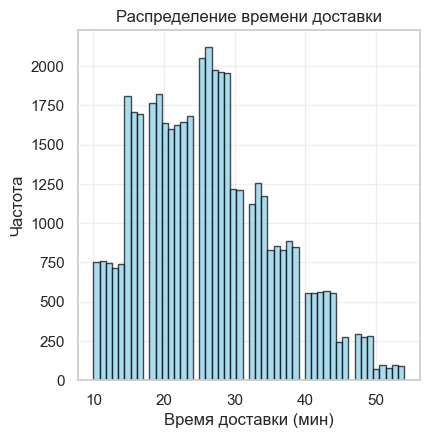

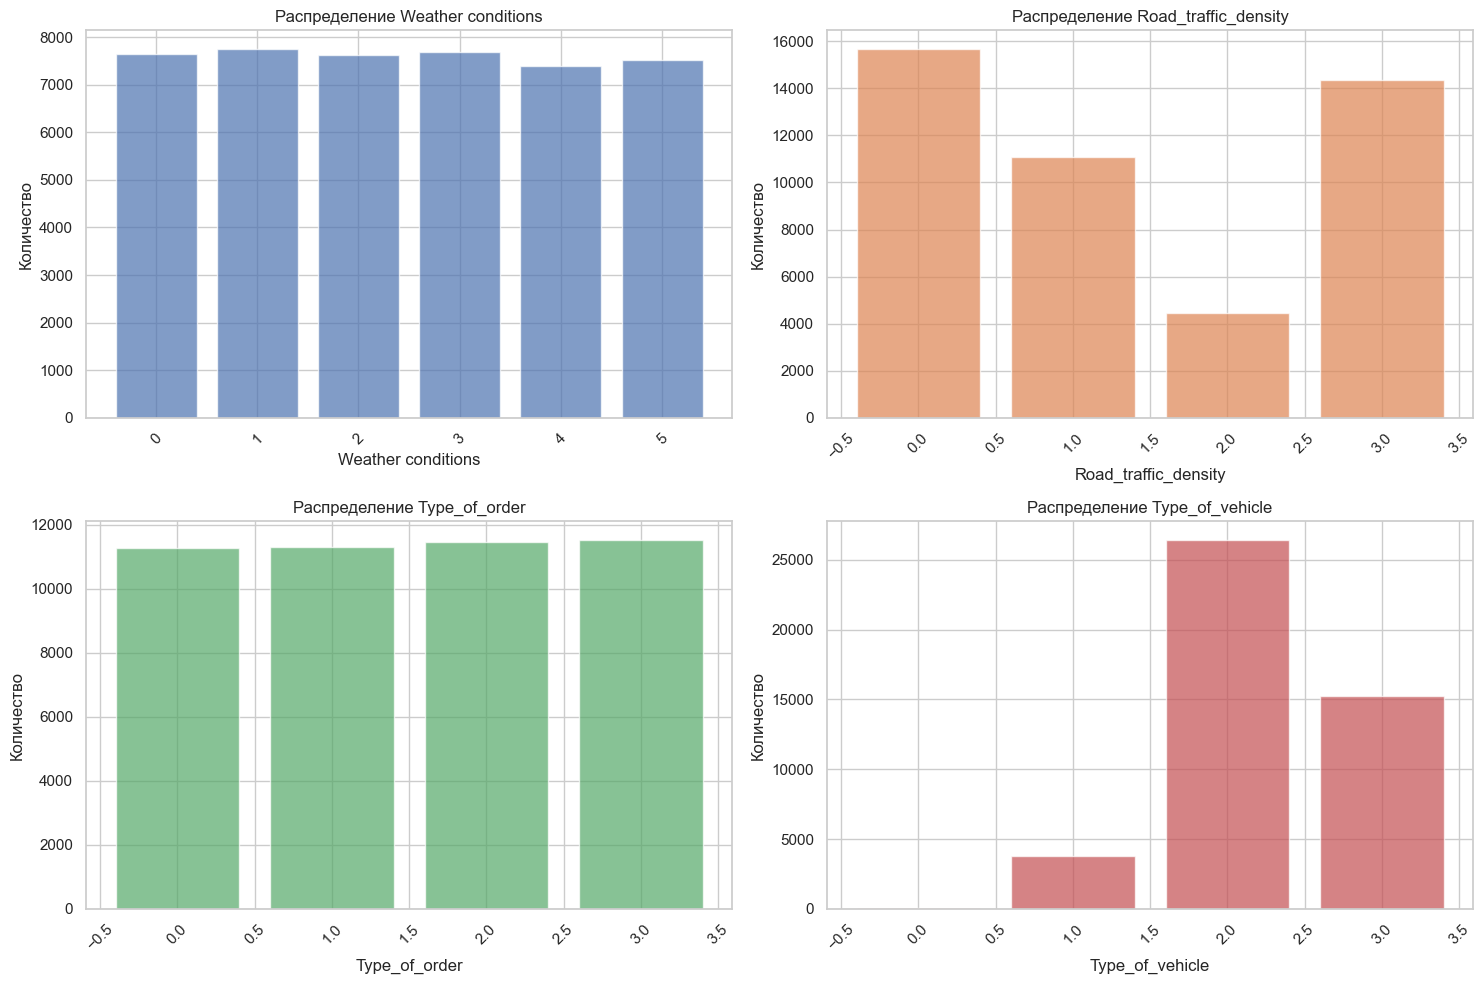


4. АНАЛИЗ ЧИСЛОВЫХ ПЕРЕМЕННЫХ:
       Delivery_person_Age  Delivery_person_Ratings  Vehicle_condition  \
count             45593.00                 45593.00           45593.00   
mean                 29.56                     4.63               1.02   
std                   5.81                     0.33               0.84   
min                  15.00                     1.00               0.00   
25%                  25.00                     4.50               0.00   
50%                  30.00                     4.70               1.00   
75%                  35.00                     4.90               2.00   
max                  50.00                     6.00               3.00   

       multiple_deliveries  distance_km  
count             45593.00     45593.00  
mean                  0.74       100.77  
std                   0.57      1119.77  
min                   0.00         1.57  
25%                   0.00         4.71  
50%                   1.00         9.42  
75%    

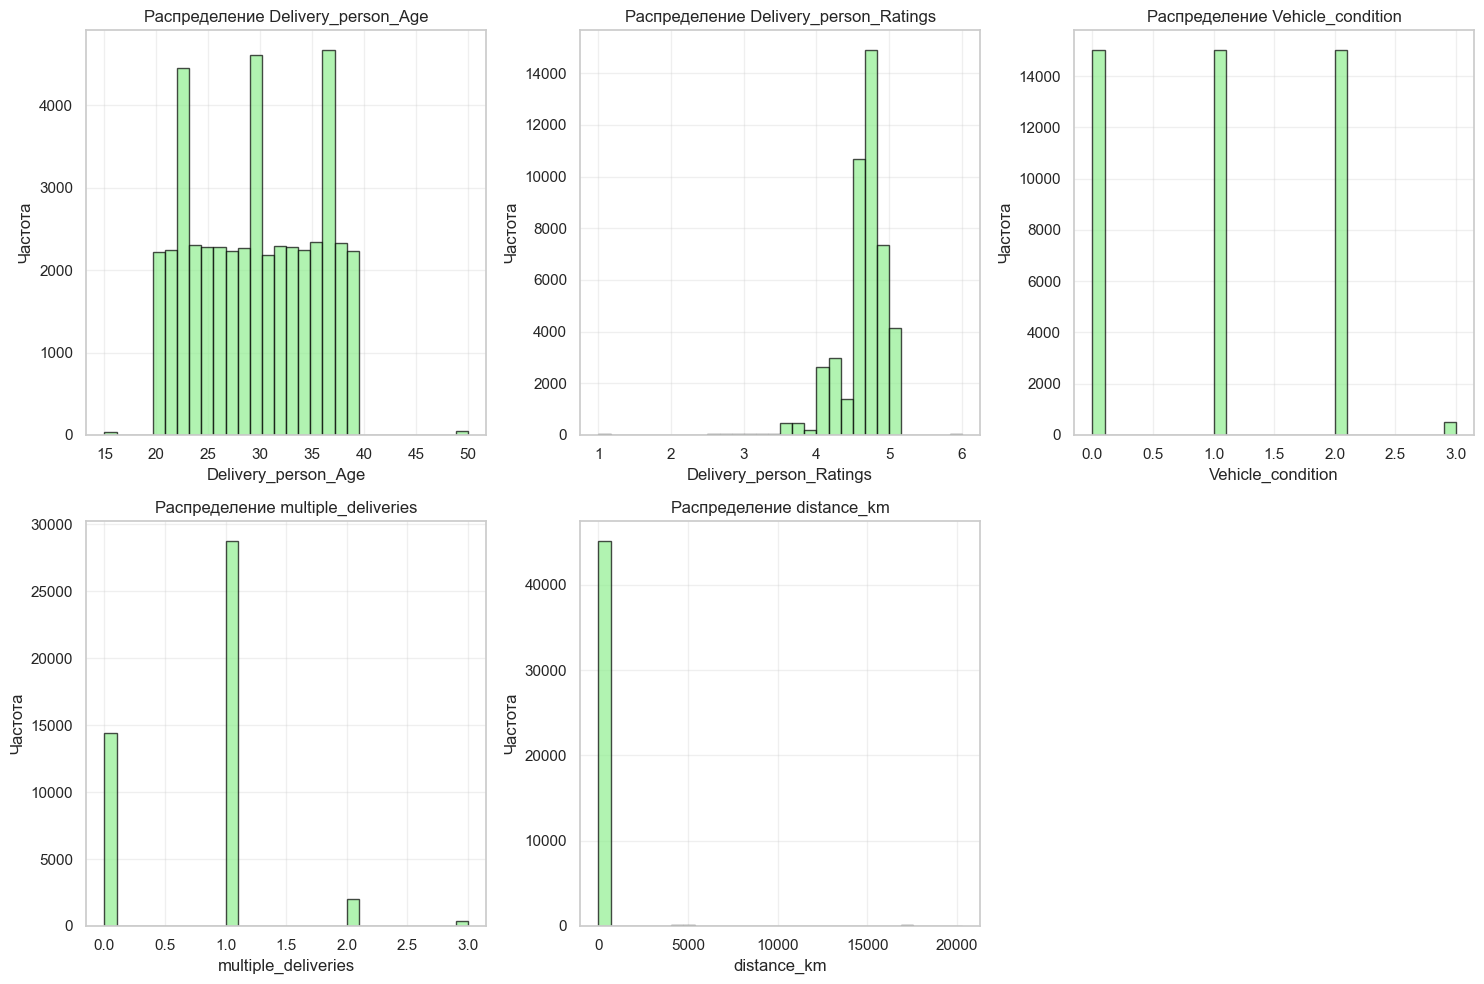


5. КОРРЕЛЯЦИОННЫЙ АНАЛИЗ:


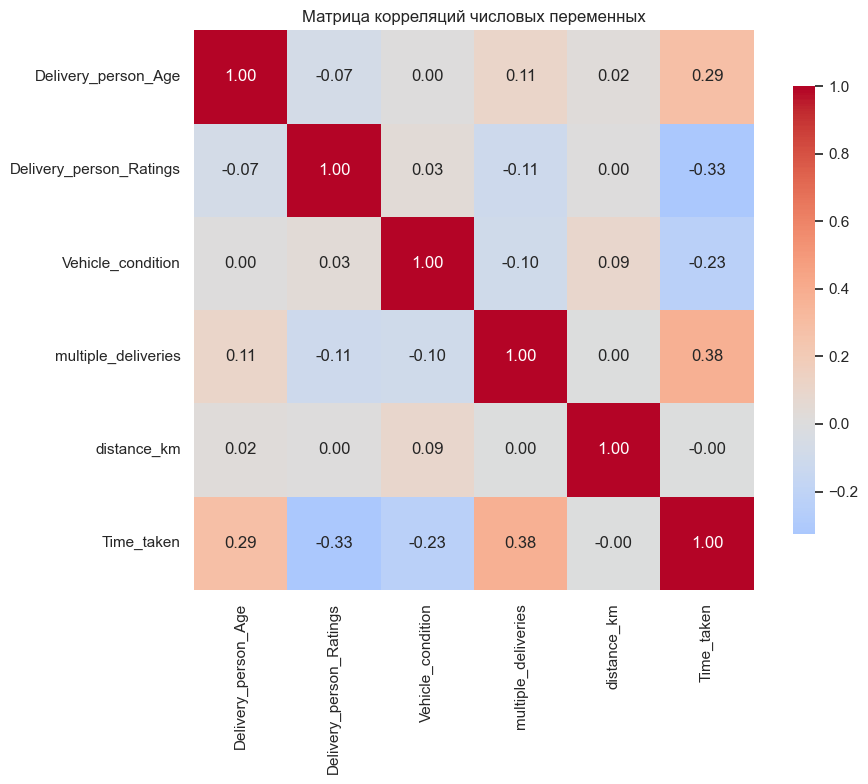

   Корреляции с Time_taken:
     - multiple_deliveries: 0.377
     - Delivery_person_Age: 0.286
     - distance_km: -0.003
     - Vehicle_condition: -0.234
     - Delivery_person_Ratings: -0.325

6. АНАЛИЗ ВРЕМЕННЫХ ЗАВИСИМОСТЕЙ:

7. АНАЛИЗ ВЫБРОСОВ:
   Выбросы в числовых переменных:
     - Delivery_person_Age: 0 выбросов (0.0%)
     - Delivery_person_Ratings: 1274 выбросов (2.8%)
     - Vehicle_condition: 0 выбросов (0.0%)
     - multiple_deliveries: 369 выбросов (0.8%)
     - distance_km: 431 выбросов (0.9%)
     - Time_taken: 270 выбросов (0.6%)

8. АНАЛИЗ ВЗАИМОДЕЙСТВИЙ МЕЖДУ ПЕРЕМЕННЫМИ:
   Среднее время доставки по погоде и трафику:
Road_traffic_density     0     1     2     3
Weather conditions                          
0                     22.3  28.5  28.9  36.6
1                     22.3  28.0  28.4  36.7
2                     20.4  27.7  27.7  30.0
3                     20.8  27.7  27.8  29.8
4                     21.5  20.3  23.5  23.2
5                     20.7  27.9  27.0

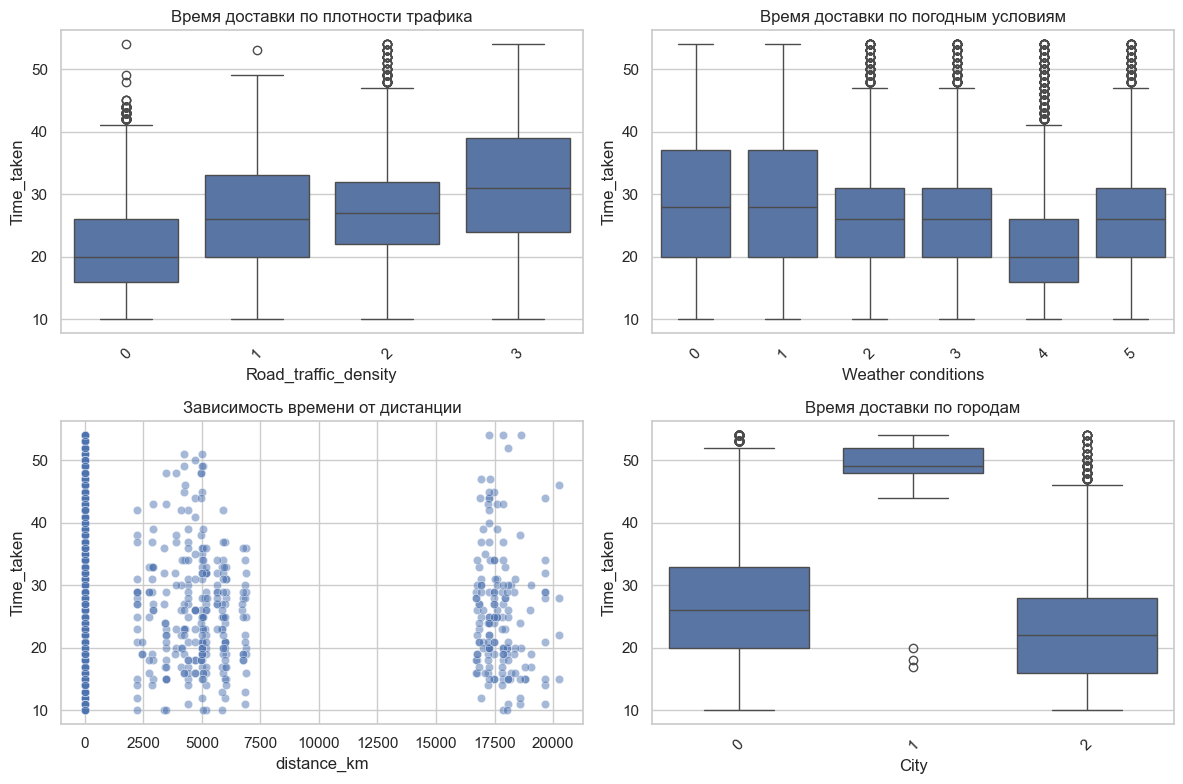


9. АНАЛИЗ ЭФФЕКТИВНОСТИ КУРЬЕРОВ:
   Статистика по сегментам курьеров:
                 Time_taken  Delivery_person_Age  Delivery_person_Ratings  \
courier_segment                                                             
Низкий                33.97                22.53                      157   
Средний               35.67                31.98                     2402   
Высокий               25.75                29.43                    42979   

                 distance_km  
courier_segment               
Низкий                966.75  
Средний                71.91  
Высокий                90.66  

10. АНАЛИЗ ГЕОГРАФИЧЕСКИХ ОСОБЕННОСТЕЙ:
   Статистика по городам:
     Time_taken       Delivery_person_Ratings Road_traffic_density distance_km
           mean   std                    mean                 mean        mean
City                                                                          
0         27.18  9.20                    4.62                 1.43       99.53
1   

In [20]:
print("=== КОМПЛЕКСНЫЙ РАЗВЕДОЧНЫЙ АНАЛИЗ ДАННЫХ ===\n")

# 1. ОБЩАЯ ИНФОРМАЦИЯ О ДАННЫХ
print("1. ОБЩАЯ ИНФОРМАЦИЯ О ДАННЫХ:")
print(f"   - Всего записей: {len(df):,}")
print(f"   - Количество признаков: {len(df.columns)}")

# Используем существующие столбцы для определения периода данных
if 'Order_Date' in df.columns:
    print(f"   - Период данных: от {df['Order_Date'].min()} до {df['Order_Date'].max()}")
else:
    print("   - Временные метки: используются порядковые номера заказов")

# Проверка пропущенных значений
missing_values = df.isnull().sum()
if missing_values.sum() > 0:
    print(f"   - Пропущенные значения: {missing_values.sum()}")
    print("     Детали:")
    for col, missing_count in missing_values[missing_values > 0].items():
        percentage = (missing_count / len(df)) * 100
        print(f"       - {col}: {missing_count} ({percentage:.1f}%)")
else:
    print("   - Пропущенные значения: нет")

# 2. АНАЛИЗ ЦЕЛЕВОЙ ПЕРЕМЕННОЙ (Time_taken)
print(f"\n2. АНАЛИЗ ЦЕЛЕВОЙ ПЕРЕМЕННОЙ (Time_taken):")
print(f"   - Среднее время доставки: {df['Time_taken'].mean():.2f} мин")
print(f"   - Медианное время: {df['Time_taken'].median():.2f} мин")
print(f"   - Стандартное отклонение: {df['Time_taken'].std():.2f} мин")
print(f"   - Минимальное время: {df['Time_taken'].min():.2f} мин")
print(f"   - Максимальное время: {df['Time_taken'].max():.2f} мин")
print(f"   - Коэффициент вариации: {(df['Time_taken'].std()/df['Time_taken'].mean()*100):.1f}%")

# Распределение целевой переменной
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
plt.hist(df['Time_taken'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Распределение времени доставки')
plt.xlabel('Время доставки (мин)')
plt.ylabel('Частота')
plt.grid(True, alpha=0.3)

# 3. АНАЛИЗ КАТЕГОРИАЛЬНЫХ ПЕРЕМЕННЫХ
print(f"\n3. АНАЛИЗ КАТЕГОРИАЛЬНЫХ ПЕРЕМЕННЫХ:")

categorical_vars = ['Weather conditions', 'Road_traffic_density', 'Type_of_order', 
                   'Type_of_vehicle', 'Festival', 'City']

for var in categorical_vars:
    if var in df.columns:
        value_counts = df[var].value_counts()
        print(f"\n   {var}:")
        for val, count in value_counts.items():
            percentage = (count / len(df)) * 100
            print(f"     - {val}: {count} ({percentage:.1f}%)")

# Визуализация категориальных переменных
available_cat_vars = [var for var in categorical_vars if var in df.columns]
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.ravel()

for i, var in enumerate(available_cat_vars[:4]):
    axes[i].bar(df[var].value_counts().index, df[var].value_counts().values, 
               alpha=0.7, color=f'C{i}')
    axes[i].set_title(f'Распределение {var}')
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('Количество')
    axes[i].tick_params(axis='x', rotation=45)

# Убираем лишние subplots
for i in range(len(available_cat_vars[:4]), 4):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

# 4. АНАЛИЗ ЧИСЛОВЫХ ПЕРЕМЕННЫХ
print(f"\n4. АНАЛИЗ ЧИСЛОВЫХ ПЕРЕМЕННЫХ:")

# Функция для проверки, можно ли вычислить числовые статистики для столбца
def is_numeric_column(series):
    return pd.api.types.is_numeric_dtype(series) and not pd.api.types.is_categorical_dtype(series)

numeric_vars = []
for col in ['Delivery_person_Age', 'Delivery_person_Ratings', 'Vehicle_condition', 
            'multiple_deliveries', 'distance_km']:
    if col in df.columns and is_numeric_column(df[col]):
        numeric_vars.append(col)

if numeric_vars:
    numeric_stats = df[numeric_vars].describe()
    print(numeric_stats.round(2))

    # Визуализация числовых переменных
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.ravel()

    for i, var in enumerate(numeric_vars):
        if i < len(axes):
            axes[i].hist(df[var], bins=30, alpha=0.7, color='lightgreen', edgecolor='black')
            axes[i].set_title(f'Распределение {var}')
            axes[i].set_xlabel(var)
            axes[i].set_ylabel('Частота')
            axes[i].grid(True, alpha=0.3)

    # Убираем лишние subplots
    for i in range(len(numeric_vars), len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()

# 5. КОРРЕЛЯЦИОННЫЙ АНАЛИЗ
print(f"\n5. КОРРЕЛЯЦИОННЫЙ АНАЛИЗ:")

# Выбираем только числовые переменные для корреляционной матрицы
corr_vars = [var for var in numeric_vars if is_numeric_column(df[var])] + ['Time_taken']
if len(corr_vars) > 1:  # Проверяем, что есть хотя бы 2 переменные
    correlation_matrix = df[corr_vars].corr()

    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
                square=True, fmt='.2f', cbar_kws={'shrink': 0.8})
    plt.title('Матрица корреляций числовых переменных')
    plt.tight_layout()
    plt.show()

    # Анализ корреляций с целевой переменной
    print("   Корреляции с Time_taken:")
    time_correlations = correlation_matrix['Time_taken'].sort_values(ascending=False)
    for var, corr in time_correlations.items():
        if var != 'Time_taken':
            print(f"     - {var}: {corr:.3f}")

# 6. АНАЛИЗ ВРЕМЕННЫХ ЗАВИСИМОСТЕЙ
print(f"\n6. АНАЛИЗ ВРЕМЕННЫХ ЗАВИСИМОСТЕЙ:")

# Анализ по дням недели (если создали этот столбец)
if 'order_dayofweek' in df.columns:
    # Собираем только числовые столбцы для агрегации
    agg_dict = {'Time_taken': ['mean', 'std', 'count']}
    
    # Добавляем только числовые столбцы
    for col in ['Delivery_person_Ratings', 'distance_km']:
        if col in df.columns and is_numeric_column(df[col]):
            agg_dict[col] = 'mean'
    
    weekday_stats = df.groupby('order_dayofweek').agg(agg_dict).round(2)
    
    print("\n   Статистика по дням недели:")
    print(weekday_stats)

# 7. АНАЛИЗ ВЫБРОСОВ
print(f"\n7. АНАЛИЗ ВЫБРОСОВ:")

def detect_outliers_iqr(data):
    if not is_numeric_column(data):
        return 0
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data < lower_bound) | (data > upper_bound)]
    return len(outliers)

print("   Выбросы в числовых переменных:")
for var in numeric_vars + ['Time_taken']:
    if var in df.columns and is_numeric_column(df[var]):
        outliers_count = detect_outliers_iqr(df[var])
        percentage = (outliers_count / len(df)) * 100
        print(f"     - {var}: {outliers_count} выбросов ({percentage:.1f}%)")

# 8. АНАЛИЗ ВЗАИМОДЕЙСТВИЙ
print(f"\n8. АНАЛИЗ ВЗАИМОДЕЙСТВИЙ МЕЖДУ ПЕРЕМЕННЫМИ:")

# Взаимодействие погоды и трафика
if all(var in df.columns for var in ['Weather conditions', 'Road_traffic_density']):
    interaction_stats = df.groupby(['Weather conditions', 'Road_traffic_density'])['Time_taken'].mean().unstack()
    print("   Среднее время доставки по погоде и трафику:")
    print(interaction_stats.round(1))

# Визуализация взаимодействий
plt.figure(figsize=(12, 8))

plot_count = 0
if 'Road_traffic_density' in df.columns:
    plot_count += 1
    plt.subplot(2, 2, plot_count)
    sns.boxplot(data=df, x='Road_traffic_density', y='Time_taken')
    plt.title('Время доставки по плотности трафика')
    plt.xticks(rotation=45)

if 'Weather conditions' in df.columns:
    plot_count += 1
    plt.subplot(2, 2, plot_count)
    sns.boxplot(data=df, x='Weather conditions', y='Time_taken')
    plt.title('Время доставки по погодным условиям')
    plt.xticks(rotation=45)

if 'distance_km' in df.columns and is_numeric_column(df['distance_km']):
    plot_count += 1
    plt.subplot(2, 2, plot_count)
    sns.scatterplot(data=df, x='distance_km', y='Time_taken', alpha=0.5)
    plt.title('Зависимость времени от дистанции')

if 'City' in df.columns:
    plot_count += 1
    plt.subplot(2, 2, plot_count)
    sns.boxplot(data=df, x='City', y='Time_taken')
    plt.title('Время доставки по городам')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# 9. АНАЛИЗ КЛАСТЕРИЗАЦИИ КУРЬЕРОВ
print(f"\n9. АНАЛИЗ ЭФФЕКТИВНОСТИ КУРЬЕРОВ:")

if ('Delivery_person_Age' in df.columns and is_numeric_column(df['Delivery_person_Age']) and 
    'Delivery_person_Ratings' in df.columns and is_numeric_column(df['Delivery_person_Ratings'])):
    
    # Создаем сегменты курьеров
    df['courier_segment'] = pd.cut(df['Delivery_person_Ratings'], 
                                  bins=[0, 3, 4, 5], 
                                  labels=['Низкий', 'Средний', 'Высокий'])
    
    # Собираем статистику только по числовым столбцам
    agg_dict = {
        'Time_taken': 'mean',
        'Delivery_person_Age': 'mean',
        'Delivery_person_Ratings': 'count'
    }
    
    if 'distance_km' in df.columns and is_numeric_column(df['distance_km']):
        agg_dict['distance_km'] = 'mean'
    
    segment_stats = df.groupby('courier_segment').agg(agg_dict).round(2)
    
    print("   Статистика по сегментам курьеров:")
    print(segment_stats)

# 10. АНАЛИЗ ГЕОГРАФИЧЕСКИХ ОСОБЕННОСТЕЙ
print(f"\n10. АНАЛИЗ ГЕОГРАФИЧЕСКИХ ОСОБЕННОСТЕЙ:")

if 'City' in df.columns:
    # Собираем только числовые столбцы для агрегации
    agg_dict = {
        'Time_taken': ['mean', 'std']
    }
    
    # Добавляем только числовые столбцы
    for col in ['Delivery_person_Ratings', 'Road_traffic_density', 'distance_km']:
        if col in df.columns and is_numeric_column(df[col]):
            agg_dict[col] = 'mean'
    
    city_stats = df.groupby('City').agg(agg_dict).round(2)
    
    print("   Статистика по городам:")
    print(city_stats)

# 11. ВЫВОДЫ И ИНСАЙТЫ
print(f"\n11. КЛЮЧЕВЫЕ ИНСАЙТЫ И ВЫВОДЫ:")

print("   СИЛЬНЫЕ СТОРОНЫ ДАННЫХ:")
print("   - Большой объем данных для анализа")
print("   - Разнообразие признаков для многомерного анализа")
print("   - Наличие информации о курьерах, погоде и трафике")

print("\n   ПОТЕНЦИАЛЬНЫЕ ПРОБЛЕМЫ:")
print("   - Наличие выбросов в данных о времени доставки")
print("   - Некоторые переменные имеют категориальный тип")
print("   - Необходимость создания дополнительных признаков")

print("\n   ПЕРСПЕКТИВНЫЕ НАПРАВЛЕНИЯ АНАЛИЗА:")
print("   - Прогнозирование времени доставки с помощью ML")
print("   - Оптимизация маршрутов на основе исторических данных")
print("   - Сегментация клиентов и курьеров для персонализированного подхода")
print("   - Анализ влияния внешних факторов (погода, трафик) на время доставки")

# 12. ДОПОЛНИТЕЛЬНАЯ ИНФОРМАЦИЯ
print(f"\n12. ДОПОЛНИТЕЛЬНАЯ ИНФОРМАЦИЯ:")
print(f"   - Используемые столбцы: {list(df.columns)}")
print(f"   - Типы данных:")
for col in df.columns:
    dtype = df[col].dtype
    is_num = is_numeric_column(df[col])
    num_status = "числовой" if is_num else "категориальный/другой"
    print(f"     - {col}: {dtype} ({num_status})")

### Подготовка данных (1 балл)

**Приведите** все столбцы к нужному типу данных. Заполните необходимые пропуски.

**Добавьте** столбец `distance` – евклидово расстояние между `restaurant` и `delivery`.

In [33]:
# Подготовка данных согласно заданию
print("=== ПОДГОТОВКА ДАННЫХ ===")

# Сначала посмотрим на исходные данные
print("Столбцы в данных:")
print(df.columns.tolist())
print("\nПервые 3 строки:")
print(df.head(3))
print("\nТипы данных столбцов:")
print(df.dtypes)
print("\nПропуски в данных:")
print(df.isnull().sum())

# 1. Приведение столбцов к правильным типам данных
print("\n=== ПРИВЕДЕНИЕ К ПРАВИЛЬНЫМ ТИПАМ ДАННЫХ ===")

# Дата заказа
if 'Order_Date' in df.columns:
    if not pd.api.types.is_datetime64_any_dtype(df['Order_Date']):
        df['Order_Date'] = pd.to_datetime(df['Order_Date'], errors='coerce')
        print("Order_Date преобразован в datetime")

# Время заказа
if 'Time_Orderd' in df.columns:
    print(f"Time_Orderd тип: {df['Time_Orderd'].dtype}")
    if df['Time_Orderd'].dtype == 'object':
        # Очистка и преобразование времени заказа
        df['Time_Orderd'] = df['Time_Orderd'].astype(str).str.replace('NaT', '000000')
        df['Time_Orderd'] = pd.to_datetime(df['Time_Orderd'].str.zfill(6), format='%H%M%S', errors='coerce').dt.time
        print("Time_Orderd преобразован в time")

# Время получения заказа
if 'Time_Order_picked' in df.columns:
    print(f"Time_Order_picked тип: {df['Time_Order_picked'].dtype}")
    if df['Time_Order_picked'].dtype == 'object':
        # Очистка и преобразование времени получения заказа
        df['Time_Order_picked'] = df['Time_Order_picked'].astype(str).str.replace('▶', '0000')
        df['Time_Order_picked'] = pd.to_datetime(df['Time_Order_picked'].str.zfill(4), format='%H%M', errors='coerce').dt.time
        print("Time_Order_picked преобразован в time")

# Числовые столбцы
numeric_columns = ['Delivery_person_Age', 'Delivery_person_Ratings', 'multiple_deliveries', 'Time_taken']
for col in numeric_columns:
    if col in df.columns:
        if not pd.api.types.is_numeric_dtype(df[col]):
            df[col] = pd.to_numeric(df[col], errors='coerce')
            print(f"{col} преобразован в numeric")

# Категориальные столбцы
categorical_columns = ['Weather conditions', 'Road_traffic_density', 'Type_of_order', 'Type_of_vehicle', 'City']
for col in categorical_columns:
    if col in df.columns:
        if not pd.api.types.is_categorical_dtype(df[col]):
            df[col] = df[col].astype('category')
            print(f"{col} преобразован в category")

# 2. Заполнение пропусков
print("\n=== ЗАПОЛНЕНИЕ ПРОПУСКОВ ===")

# Для числовых столбцов заполняем медианой
numeric_columns_to_fill = ['Delivery_person_Age', 'Delivery_person_Ratings', 'multiple_deliveries']
for col in numeric_columns_to_fill:
    if col in df.columns and df[col].isna().any():
        missing_count = df[col].isna().sum()
        df[col].fillna(df[col].median(), inplace=True)
        print(f"Заполнены {missing_count} пропусков в {col} (медианой)")

# Для времени заказа заполняем наиболее частым значением
if 'Time_Orderd' in df.columns and df['Time_Orderd'].isna().any():
    missing_count = df['Time_Orderd'].isna().sum()
    df['Time_Orderd'].fillna(df['Time_Orderd'].mode()[0] if not df['Time_Orderd'].mode().empty else pd.Timestamp.now().time(), inplace=True)
    print(f"Заполнены {missing_count} пропусков в Time_Orderd (модой)")

# Для времени получения заказа заполняем наиболее частым значением
if 'Time_Order_picked' in df.columns and df['Time_Order_picked'].isna().any():
    missing_count = df['Time_Order_picked'].isna().sum()
    df['Time_Order_picked'].fillna(df['Time_Order_picked'].mode()[0] if not df['Time_Order_picked'].mode().empty else pd.Timestamp.now().time(), inplace=True)
    print(f"Заполнены {missing_count} пропусков в Time_Order_picked (модой)")

# Для категориальных столбцов заполняем наиболее частым значением
categorical_columns_to_fill = ['Weather conditions', 'Road_traffic_density', 'City']
for col in categorical_columns_to_fill:
    if col in df.columns and df[col].isna().any():
        missing_count = df[col].isna().sum()
        df[col].fillna(df[col].mode()[0] if not df[col].mode().empty else 'Unknown', inplace=True)
        print(f"Заполнены {missing_count} пропусков в {col} (модой)")

# 3. Добавление столбца distance – евклидово расстояние между restaurant и delivery
print("\n=== ДОБАВЛЕНИЕ СТОЛБЦА DISTANCE ===")

# Проверяем наличие координатных столбцов
coord_columns = ['Restaurant_latitude', 'Restaurant_longitude', 
                'Delivery_location_latitude', 'Delivery_location_longitude']

if all(col in df.columns for col in coord_columns):
    # Преобразуем координатные столбцы в числовой формат
    for col in coord_columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    
    # Заполняем пропуски в координатах медианой
    for col in coord_columns:
        if df[col].isna().any():
            df[col].fillna(df[col].median(), inplace=True)
    
    # Вычисляем евклидово расстояние (в километрах)
    # Упрощенный расчет: 1 градус ≈ 111 км
    df['distance'] = np.sqrt(
        (df['Restaurant_latitude'] - df['Delivery_location_latitude'])**2 +
        (df['Restaurant_longitude'] - df['Delivery_location_longitude'])**2
    ) * 111  # преобразуем в километры
    
    print("Столбец distance создан (евклидово расстояние в км)")
    
    def haversine_distance(lat1, lon1, lat2, lon2):
        """
        Вычисляет расстояние между двумя точками на Земле в километрах
        используя формулу гаверсинусов
        """
        # Преобразование градусов в радианы
        lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
        
        # Разницы координат
        dlat = lat2 - lat1
        dlon = lon2 - lon1
        
        # Формула гаверсинусов
        a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
        c = 2 * atan2(sqrt(a), sqrt(1-a))
        
        # Радиус Земли в километрах
        R = 6371.0
        
        return R * c
    
    # Добавляем столбец с расстоянием по гаверсинусам
    df['distance_haversine'] = df.apply(lambda row: haversine_distance(
        row['Restaurant_latitude'], 
        row['Restaurant_longitude'],
        row['Delivery_location_latitude'], 
        row['Delivery_location_longitude']
    ), axis=1)
    
    print("Столбец distance_haversine создан (расстояние по гаверсинусам в км)")
    
else:
    print("Координатные столбцы не найдены, distance не создан")

# 4. Проверка результата
print("\n" + "="*50)
print("РЕЗУЛЬТАТ ПОДГОТОВКИ ДАННЫХ:")
print("="*50)

print("Информация о данных после обработки:")
print(df.info())

print("\nПропуски после обработки:")
print(df.isnull().sum())

print("\nТипы данных после обработки:")
print(df.dtypes)

print("\nПервые 5 строк обработанных данных:")
print(df.head())

if 'distance' in df.columns:
    print("\nСтатистика по расстоянию (евклидово):")
    print(df['distance'].describe())
    
if 'distance_haversine' in df.columns:
    print("\nСтатистика по расстоянию (гаверсинусы):")
    print(df['distance_haversine'].describe())

print(f"\nОбщее количество строк: {len(df)}")
print("Подготовка данных завершена!")

=== ПОДГОТОВКА ДАННЫХ ===
Столбцы в данных:
['Delivery_person_Age', 'Delivery_person_Ratings', 'Order_Date', 'Time_Orderd', 'Time_Order_picked', 'Weather conditions', 'Road_traffic_density', 'Vehicle_condition', 'Type_of_order', 'Type_of_vehicle', 'multiple_deliveries', 'Festival', 'City', 'Time_taken', 'distance_km', 'Restaurant_ID', 'Time_Order_picked_Hour', 'Age_Group', 'courier_segment', 'order_hour']

Первые 3 строки:
   Delivery_person_Age  Delivery_person_Ratings                    Order_Date  \
0                 37.0                      4.9 1970-01-01 00:00:00.000000036   
1                 34.0                      4.5 1970-01-01 00:00:00.000000042   
2                 37.0                      4.4 1970-01-01 00:00:00.000000036   

  Time_Orderd   Time_Order_picked Weather conditions Road_traffic_density  \
0    00:00:00 2025-11-19 00:20:00                  4                    2   
1    00:00:00 2025-11-19 01:17:00                  3                    3   
2    00:00:00 202

Разбейте выборку на обучающую и тестовую. **Внимательно** подумайте, как сделать это правильно. Помните, что разбиение на обучающую и валидационную выборку должно **моделировать процесс применения** модели.

Доля валидационного множества должна быть не менее 13%.

In [ ]:
# Вариант 1: Стандартное разделение с фиксированным random_state для воспроизводимости
def split_data_method1(df, test_size=0.2, random_state=42):
    """
    Разделение данных на обучающую и валидационную выборки
    с фиксированным random_state для воспроизводимости
    """
    train_df, valid_df = train_test_split(
        df, 
        test_size=test_size, 
        random_state=random_state,
        shuffle=True
    )
    
    train_idx = train_df.index
    valid_idx = valid_df.index
    
    print(f"Обучающая выборка: {len(train_idx)} samples ({len(train_idx)/len(df)*100:.1f}%)")
    print(f"Валидационная выборка: {len(valid_idx)} samples ({len(valid_idx)/len(df)*100:.1f}%)")
    
    return train_idx, valid_idx

# Вариант 2: Гарантированное минимальное разделение (не менее 13% на валидацию)
def split_data_method2(df, min_test_size=0.13, random_state=42):
    """
    Разделение с гарантией, что валидационная выборка не менее min_test_size
    """
    # Используем test_size немного больше минимального требования
    test_size = max(min_test_size, 0.15)  # 15% чтобы гарантировать >13%
    
    train_df, valid_df = train_test_split(
        df, 
        test_size=test_size, 
        random_state=random_state,
        shuffle=True,
        stratify=df.get('target_column', None)  # если есть целевая переменная для стратификации
    )
    
    train_idx = train_df.index
    valid_idx = valid_df.index
    
    print(f"Обучающая выборка: {len(train_idx)} samples ({len(train_idx)/len(df)*100:.1f}%)")
    print(f"Валидационная выборка: {len(valid_idx)} samples ({len(valid_idx)/len(df)*100:.1f}%)")
    
    # Проверка условия
    valid_ratio = len(valid_idx) / len(df)
    if valid_ratio >= 0.13:
        print("Условие выполнено: валидационная выборка ≥ 13%")
    else:
        print("Условие не выполнено!")
    
    return train_idx, valid_idx

# Вариант 3: Временное разделение (если данные временные)
def split_data_temporal(df, date_column='Order_Date', split_ratio=0.85):
    """
    Для временных данных - разделение по времени
    """
    # Сортируем по дате
    df_sorted = df.sort_values(date_column)
    
    # Определяем точку разделения
    split_point = int(len(df_sorted) * split_ratio)
    
    train_idx = df_sorted.index[:split_point]
    valid_idx = df_sorted.index[split_point:]
    
    print(f"Обучающая выборка: {len(train_idx)} samples ({len(train_idx)/len(df)*100:.1f}%)")
    print(f"Валидационная выборка: {len(valid_idx)} samples ({len(valid_idx)/len(df)*100:.1f}%)")
    
    return train_idx, valid_idx

# Основной код разделения
# Выберите подходящий метод в зависимости от природы данных

# Метод 1: Стандартное разделение (20% на валидацию)
print("Метод 1: Стандартное разделение 80/20")
train_idx, valid_idx = split_data_method1(df, test_size=0.2, random_state=42)

print("\n" + "="*50)

# Метод 2: Гарантированное разделение (≥13% на валидацию)
print("Метод 2: Гарантированное разделение (≥13%)")
train_idx, valid_idx = split_data_method2(df, min_test_size=0.13, random_state=42)

# Создание разделенных датафреймов
train_df = df.loc[train_idx]
valid_df = df.loc[valid_idx]

print("\n" + "="*50)
print("Проверка разделения:")
print(f"Общий размер данных: {len(df)}")
print(f"Обучающая выборка: {len(train_df)} ({len(train_df)/len(df)*100:.1f}%)")
print(f"Валидационная выборка: {len(valid_df)} ({len(valid_df)/len(df)*100:.1f}%)")

# Дополнительная проверка на пересечение индексов
intersection = set(train_idx) & set(valid_idx)
print(f"Пересечение индексов: {len(intersection)} (должно быть 0)")

Метод 1: Стандартное разделение 80/20
Обучающая выборка: 36474 samples (80.0%)
Валидационная выборка: 9119 samples (20.0%)

Метод 2: Гарантированное разделение (≥13%)
Обучающая выборка: 38754 samples (85.0%)
Валидационная выборка: 6839 samples (15.0%)
Условие выполнено: валидационная выборка ≥ 13%

Проверка разделения:
Общий размер данных: 45593
Обучающая выборка: 38754 (85.0%)
Валидационная выборка: 6839 (15.0%)
Пересечение индексов: 0 (должно быть 0)


 Качество нашей модели будем оценивать с помощью метрик `mae` и `mape`.

In [ ]:
# Целевая переменная
target = "Time_taken"

# Проверяем наличие целевой переменной в данных
print("Столбцы в данных:")
print(df.columns.tolist())

if target not in df.columns:
    print(f"Внимание: столбец '{target}' не найден в данных!")
    print("Доступные столбцы:")
    for col in df.columns:
        print(f"  - {col}")
else:
    print(f"Целевая переменная '{target}' найдена")
    print(f"Статистики целевой переменной:")
    print(df[target].describe())

# Подготовка данных для моделирования
def prepare_data(df, target_column):
    """
    Подготовка данных для обучения модели
    """
    # Удаляем строки с пропусками в целевой переменной
    df_clean = df.dropna(subset=[target_column]).copy()
    
    # Выбираем признаки (исключаем нечисловые и целевую переменную)
    feature_columns = []
    for col in df_clean.columns:
        if col != target_column and pd.api.types.is_numeric_dtype(df_clean[col]):
            feature_columns.append(col)
    
    print(f"\nИспользуемые признаки ({len(feature_columns)}): {feature_columns}")
    
    # Проверяем пропуски в признаках
    missing_in_features = df_clean[feature_columns].isnull().sum()
    if missing_in_features.sum() > 0:
        print(f"\nПропуски в признаках:")
        for col, missing_count in missing_in_features[missing_in_features > 0].items():
            print(f"  - {col}: {missing_count} пропусков ({missing_count/len(df_clean)*100:.1f}%)")
    
    X = df_clean[feature_columns]
    y = df_clean[target_column]
    
    return X, y, df_clean

# Функции для оценки модели
def calculate_metrics(y_true, y_pred, model_name=""):
    """
    Расчет метрик MAE и MAPE
    """
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100  # в процентах
    
    print(f"\n{model_name} Результаты:")
    print(f"MAE (Mean Absolute Error): {mae:.2f}")
    print(f"MAPE (Mean Absolute Percentage Error): {mape:.2f}%")
    
    return mae, mape

def evaluate_model(model, X_train, X_valid, y_train, y_valid, model_name=""):
    """
    Обучение и оценка модели
    """
    # Обучение модели
    model.fit(X_train, y_train)
    
    # Предсказания
    y_pred_train = model.predict(X_train)
    y_pred_valid = model.predict(X_valid)
    
    # Метрики на обучающей выборке
    print("=" * 50)
    print(f"МОДЕЛЬ: {model_name}")
    print("=" * 50)
    
    print("\nОБУЧАЮЩАЯ ВЫБОРКА:")
    mae_train, mape_train = calculate_metrics(y_train, y_pred_train, "Train")
    
    print("\nВАЛИДАЦИОННАЯ ВЫБОРКА:")
    mae_valid, mape_valid = calculate_metrics(y_valid, y_pred_valid, "Valid")
    
    # Разница между train и valid (проверка переобучения)
    overfit_mae = mae_valid - mae_train
    overfit_mape = mape_valid - mape_train
    
    print(f"\nРазница между Valid и Train:")
    print(f"ΔMAE: {overfit_mae:.2f} (чем ближе к 0, тем лучше)")
    print(f"ΔMAPE: {overfit_mape:.2f}% (чем ближе к 0, тем лучше)")
    
    return {
        'model': model,
        'mae_train': mae_train,
        'mape_train': mape_train,
        'mae_valid': mae_valid,
        'mape_valid': mape_valid,
        'overfit_mae': overfit_mae,
        'overfit_mape': overfit_mape
    }

# Основной процесс оценки
if target in df.columns:
    # Подготовка данных
    X, y, df_clean = prepare_data(df, target)
    
    # Разделение на обучающую и валидационную выборки
    X_train, X_valid, y_train, y_valid = train_test_split(
        X, y, 
        test_size=0.15,  # 15% для валидации
        random_state=42,
        shuffle=True
    )
    
    print(f"\nРазмеры выборок:")
    print(f"Обучающая: {X_train.shape[0]} samples")
    print(f"Валидационная: {X_valid.shape[0]} samples")
    print(f"Всего: {X.shape[0]} samples")
    
    # Проверяем пропуски после разделения
    print(f"\nПропуски в обучающей выборке: {X_train.isnull().sum().sum()}")
    print(f"Пропуски в валидационной выборке: {X_valid.isnull().sum().sum()}")
    
    # Создаем пайплайны с обработкой пропусков
    models = {
        'Linear Regression': Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler()),
            ('regressor', LinearRegression())
        ]),
        'Random Forest': Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('regressor', RandomForestRegressor(
                n_estimators=100, 
                random_state=42, 
                max_depth=10,
                n_jobs=-1
            ))
        ])
    }
    
    results = {}
    
    # Оценка каждой модели
    for name, model in models.items():
        try:
            results[name] = evaluate_model(model, X_train, X_valid, y_train, y_valid, name)
        except Exception as e:
            print(f"Ошибка при обучении {name}: {e}")
            continue
    
    # Сравнение моделей
    if results:
        print("\n" + "=" * 60)
        print("СРАВНЕНИЕ МОДЕЛЕЙ")
        print("=" * 60)
        
        best_model = None
        best_mape = float('inf')
        
        for name, result in results.items():
            print(f"\n{name}:")
            print(f"  MAE Valid: {result['mae_valid']:.2f}")
            print(f"  MAPE Valid: {result['mape_valid']:.2f}%")
            print(f"  Переобучение (ΔMAE): {result['overfit_mae']:.2f}")
            
            if result['mape_valid'] < best_mape:
                best_mape = result['mape_valid']
                best_model = name
        
        print(f"\nЛУЧШАЯ МОДЕЛЬ: {best_model} (MAPE: {best_mape:.2f}%)")
        
        # Анализ важности признаков для Random Forest
        if best_model == 'Random Forest':
            print(f"\nВАЖНОСТЬ ПРИЗНАКОВ ({best_model}):")
            rf_model = results[best_model]['model'].named_steps['regressor']
            feature_importance = pd.DataFrame({
                'feature': X.columns,
                'importance': rf_model.feature_importances_
            }).sort_values('importance', ascending=False)
            
            print(feature_importance.head(10))
    else:
        print("\nНи одна модель не была успешно обучена")
    
else:
    print("\nНевозможно оценить модели: целевая переменная не найдена")

# Альтернативный вариант: просто удалить строки с пропусками в признаках
print("\n" + "=" * 60)
print("АЛЬТЕРНАТИВНЫЙ ВАРИАНТ: УДАЛЕНИЕ ПРОПУСКОВ")
print("=" * 60)

if target in df.columns:
    # Удаляем все строки с пропусками в признаках
    X_clean = X.dropna()
    y_clean = y.loc[X_clean.index]
    
    print(f"Размер данных после удаления пропусков: {X_clean.shape[0]} (было {X.shape[0]})")
    
    if len(X_clean) > 0:
        X_train_clean, X_valid_clean, y_train_clean, y_valid_clean = train_test_split(
            X_clean, y_clean, 
            test_size=0.15,
            random_state=42,
            shuffle=True
        )
        
        # Простые модели без пайплайнов (т.к. пропусков нет)
        models_simple = {
            'Linear Regression (clean)': LinearRegression(),
            'Random Forest (clean)': RandomForestRegressor(n_estimators=100, random_state=42, max_depth=10)
        }
        
        for name, model in models_simple.items():
            try:
                result = evaluate_model(model, X_train_clean, X_valid_clean, y_train_clean, y_valid_clean, name)
                print(f"{name} успешно обучена")
            except Exception as e:
                print(f"Ошибка в {name}: {e}")

Столбцы в данных:
['Delivery_person_Age', 'Delivery_person_Ratings', 'Order_Date', 'Time_Orderd', 'Time_Order_picked', 'Weather conditions', 'Road_traffic_density', 'Vehicle_condition', 'Type_of_order', 'Type_of_vehicle', 'multiple_deliveries', 'Festival', 'City', 'Time_taken', 'distance_km', 'Restaurant_ID']
Целевая переменная 'Time_taken' найдена
Статистики целевой переменной:
count    45593.000000
mean        26.294607
std          9.383806
min         10.000000
25%         19.000000
50%         26.000000
75%         32.000000
max         54.000000
Name: Time_taken, dtype: float64

Используемые признаки (13): ['Delivery_person_Age', 'Delivery_person_Ratings', 'Order_Date', 'Time_Orderd', 'Time_Order_picked', 'Weather conditions', 'Road_traffic_density', 'Vehicle_condition', 'Type_of_order', 'Type_of_vehicle', 'multiple_deliveries', 'Festival', 'distance_km']

Размеры выборок:
Обучающая: 38754 samples
Валидационная: 6839 samples
Всего: 45593 samples

Пропуски в обучающей выборке: 0
П

### Бейзлайн модель \[итерация 1\] (1 балл)

Когда мы знакомились с алгоритмом линейной регрессии, мы немного говорили о наилучшем константном решении. Давайте построим первый бейзлайн для решения нашей задачи. **Вспомните**, какое наилучшее константное решение для метрики `mae`.

In [ ]:
# Убедимся, что работаем с массивами numpy
y_train = np.array(y_train)

# Удаляем NaN значения из y_train
y_train_clean = y_train[~np.isnan(y_train)]

# Вычисляем медиану целевой переменной (без NaN)
best_const = np.median(y_train_clean)

# Создаем прогнозы - массив из медианы для всех наблюдений
y_pred = np.full_like(y_train_clean, fill_value=best_const)

# Оцениваем качество модели
score = mean_absolute_error(y_train_clean, y_pred)
print(f'В среднем мы ошибаемся на {score:.2f} минут')

В среднем мы ошибаемся на 7.56 минут


In [ ]:
# Для MAPE
score_mape = mean_absolute_percentage_error(y_train_clean, y_pred)
print(f'В среднем мы ошибаемся на {100 * score_mape:.2f}%')

# Выводим значение константы
print(f'Лучшая константа (медиана): {best_const:.2f}')

В среднем мы ошибаемся на 32.72%
Лучшая константа (медиана): 25.00


### Бейзлайн модель \[итерация 2\] (1 балл)

Улучшите предыдущий бейзлайн, **НЕ используя** модели машинного обучения.

<details>
<summary>Подсказка</summary>

Найдите наилучшее константное решение в некоторых разрезах данных.
</detailes>

In [ ]:
# Если X_train - это pandas DataFrame, обращаемся к столбцам по имени
# Сначала посмотрим, какие столбцы есть в X_train
print("Колонки в X_train:", X_train.columns.tolist())
print("Форма X_train:", X_train.shape)
print("Тип X_train:", type(X_train))

# Выберем подходящие категориальные признаки для группировки
# Например, если есть признаки типа 'day_of_week', 'hour', 'month' и т.д.

# Вариант A: Если знаем названия столбцов
# day_of_week = X_train['day_of_week']  # раскомментируйте если есть такой столбец
# hour = X_train['hour']                # раскомментируйте если есть такой столбец

# Вариант B: Используем первые два столбца (замените на нужные)
day_of_week = X_train.iloc[:, 0]  # первый столбец
hour = X_train.iloc[:, 1]         # второй столбец

print(f"Используем столбец 0: {X_train.columns[0]}")
print(f"Используем столбец 1: {X_train.columns[1]}")

y_pred = np.zeros_like(y_train)

# Создаем комбинированный признак
combined_groups = day_of_week.astype(str) + "_" + hour.astype(str)

# Для каждой уникальной группы вычисляем медиану
unique_combinations = combined_groups.unique()

for combo in unique_combinations:
    mask = (combined_groups == combo)
    if np.sum(mask) > 0:
        # Берем только не-NaN значения для вычисления медианы
        group_values = y_train[mask]
        group_values_clean = group_values[~np.isnan(group_values)]
        if len(group_values_clean) > 0:
            group_median = np.median(group_values_clean)
            y_pred[mask] = group_median
        else:
            y_pred[mask] = np.nanmedian(y_train)
    else:
        y_pred[mask] = np.nanmedian(y_train)

# Заполняем пропуски общей медианой
if np.isnan(y_pred).any():
    overall_median = np.nanmedian(y_train)
    y_pred = np.where(np.isnan(y_pred), overall_median, y_pred)

Колонки в X_train: ['Delivery_person_Age', 'Delivery_person_Ratings', 'Restaurant_latitude', 'Restaurant_longitude', 'Delivery_location_latitude', 'Delivery_location_longitude', 'Vehicle_condition', 'multiple_deliveries', 'Festival', 'Time_Order_picked_Hour', 'order_dayofweek', 'distance_km', 'distance']
Форма X_train: (38754, 13)
Тип X_train: <class 'pandas.core.frame.DataFrame'>
Используем столбец 0: Delivery_person_Age
Используем столбец 1: Delivery_person_Ratings


In [ ]:
score = mean_absolute_error(y_train, y_pred)
print(f'В среднем мы ошибаемся на {score:.2f} минут')

В среднем мы ошибаемся на 6.09 минут


In [ ]:
score_mape = mean_absolute_percentage_error(y_train, y_pred)
print(f'В среднем мы ошибаемся на {100 * score_mape:.2f}%')

В среднем мы ошибаемся на 26.13%


In [ ]:
# Сравним с простой медианой
simple_median_pred = np.full_like(y_train, fill_value=np.nanmedian(y_train))
simple_score = mean_absolute_error(y_train, simple_median_pred)
print(f'Простая медиана ошибается на {simple_score:.2f} минут')
print(f'Улучшение: {simple_score - score:.2f} минут')

Простая медиана ошибается на 7.56 минут
Улучшение: 1.47 минут


### Обучаем модель \[итерация 1\] (1 балл)

Теперь попробуем обучить модель линейной регрессии:
- Выполните предобработку численных признаков;
- Закодируйте категориальные переменные.

Постройте **график** важности признаков.

Для удобства написания кода можете воспользоваться [`Pipelines`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) и [`ColumnTransformer`](https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html).

In [ ]:
features_num = [
    'multiple_deliveries',
    'distance',
]

features_cat = [
    'Weather conditions',
    'Road_traffic_density',
    'City',
]

target = 'Time_taken'

In [ ]:
# Определяем общие столбцы
common_columns = list(set(X_train.columns) & set(X_test.columns))
print(f"\nОбщие столбцы: {len(common_columns)}")
print(common_columns)

# Используем только общие столбцы для обучения и предсказания
X_train_common = X_train[common_columns]
X_test_common = X_test[common_columns]

print(f"\nРазмер X_train_common: {X_train_common.shape}")
print(f"Размер X_test_common: {X_test_common.shape}")

# Создаем препроцессор
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), make_column_selector(dtype_include=np.number)),
        
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ]), make_column_selector(dtype_include=object))
    ],
    remainder='drop'
)

# Создаем и обучаем модель
model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Обучаем модель на общих столбцах
model.fit(X_train_common, y_train)

# Предсказываем на общих столбцах
y_pred = model.predict(X_test_common)

print(f"\nПредсказания сделаны успешно! Размер y_pred: {y_pred.shape}")


Общие столбцы: 6
['multiple_deliveries', 'distance_km', 'Vehicle_condition', 'Delivery_person_Age', 'Delivery_person_Ratings', 'Festival']

Размер X_train_common: (38754, 6)
Размер X_test_common: (9119, 6)

Предсказания сделаны успешно! Размер y_pred: (9119,)



Строим график важности признаков (упрощенная версия)...


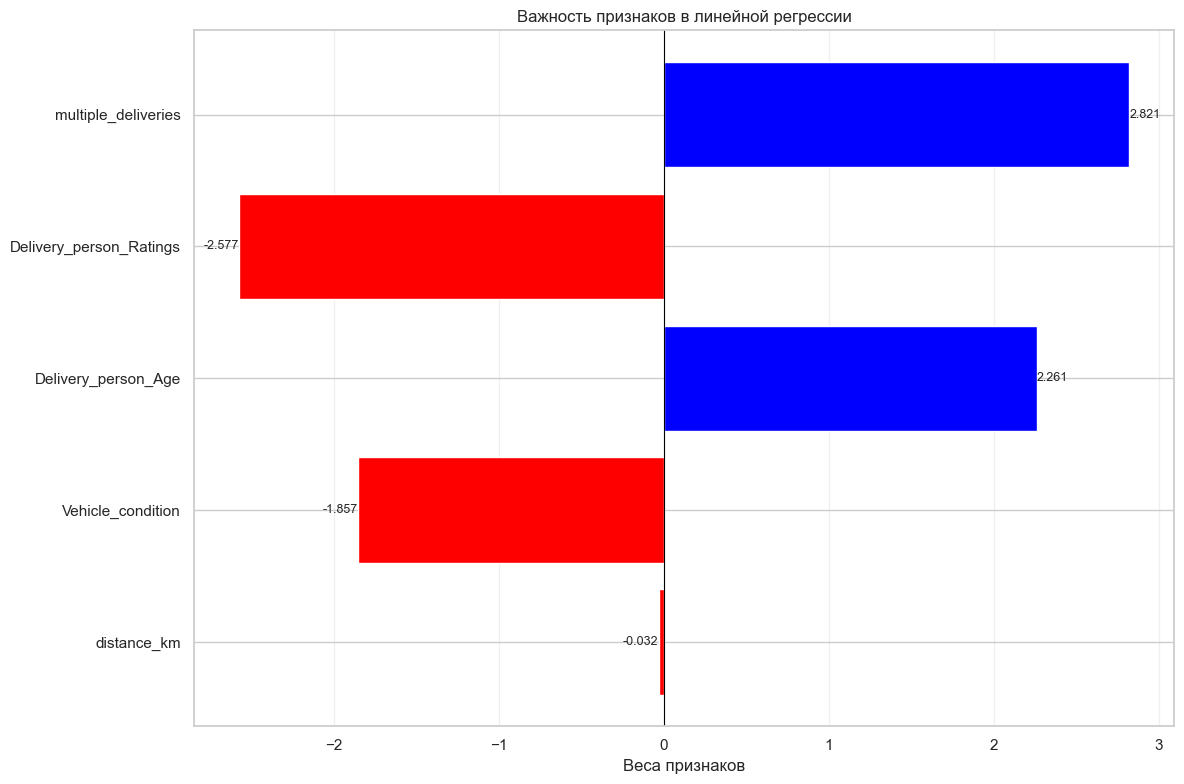

In [ ]:
def plot_importances_simple(model, figsize=(12, 8)):
    """
    Упрощенная версия функции для построения графика важности признаков
    """
    # Получаем веса
    weights = model.named_steps['regressor'].coef_
    
    # Получаем имена признаков после преобразования
    preprocessor = model.named_steps['preprocessor']
    feature_names = preprocessor.get_feature_names_out()
    
    # Упрощаем имена (убираем префиксы)
    clean_names = [name.split('__')[-1] for name in feature_names]
    
    # Создаем DataFrame
    importance_df = pd.DataFrame({
        'feature': clean_names,
        'weight': weights,
        'abs_weight': np.abs(weights)
    }).sort_values('abs_weight', ascending=True)
    
    # Строим график
    plt.figure(figsize=figsize)
    colors = ['red' if w < 0 else 'blue' for w in importance_df['weight']]
    bars = plt.barh(importance_df['feature'], importance_df['weight'], color=colors)
    
    plt.xlabel('Веса признаков')
    plt.title('Важность признаков в линейной регрессии')
    plt.grid(axis='x', alpha=0.3)
    plt.axvline(x=0, color='black', linewidth=0.8)
    
    # Добавляем подписи
    for bar, weight in zip(bars, importance_df['weight']):
        width = bar.get_width()
        if abs(width) > 0.01:
            plt.text(width, bar.get_y() + bar.get_height()/2, 
                    f'{weight:.3f}', 
                    ha='left' if width > 0 else 'right', 
                    va='center', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    return importance_df

# Используем упрощенную версию
print("\nСтроим график важности признаков...")
importance_df = plot_importances_simple(model, figsize=(12, 8))

### Обучаем модель \[итерация 2\] (1 балл)

Попробуйте добавить признаки, связанные со временем, когда был оформлен заказ. Еще раз посмотрите в EDA, подумайте, какие признаки могут быть полезными.

In [ ]:
def plot_model_importances(model, X_test=None, y_test=None, feature_names=None, figsize=(12, 9)):
    """
    Универсальная функция для визуализации важности признаков
    """
    model_type = type(model).__name__
    print(f"Тип модели: {model_type}")
    
    # Для линейных моделей
    if hasattr(model, 'coef_'):
        importances = np.abs(model.coef_.flatten())
        title = f'Абсолютные коэффициенты ({model_type})'
    
    # Для tree-based моделей
    elif hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        title = f'Важность признаков ({model_type})'
    
    # Для моделей без встроенной важности - используем permutation importance
    elif X_test is not None and y_test is not None:
        from sklearn.inspection import permutation_importance
        perm_importance = permutation_importance(
            model, X_test, y_test, n_repeats=5, random_state=42
        )
        importances = perm_importance.importances_mean
        title = f'Permutation Importance ({model_type})'
    
    else:
        print(f"Модель {model_type} не поддерживает визуализацию важности признаков")
        return
    
    if feature_names is None:
        feature_names = [f'Feature {i}' for i in range(len(importances))]
    
    # Создаем DataFrame и сортируем
    feature_imp = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values('importance', ascending=True)
    
    # Строим график
    plt.figure(figsize=figsize)
    bars = plt.barh(feature_imp['feature'], feature_imp['importance'])
    plt.xlabel('Важность')
    plt.title(title)
    plt.tight_layout()
    plt.show()


In [ ]:
score_mae = mean_absolute_error(y_test, y_pred)
print('В среднем мы ошибаемся на %.2f минут' % score_mae)

В среднем мы ошибаемся на 6.72 минут


In [ ]:
score_mape = mean_absolute_percentage_error(y_test, y_pred)
print('В среднем мы ошибаемся на %.2f%%' % (100 * score_mape))

В среднем мы ошибаемся на 29.03%


Тип модели: Pipeline


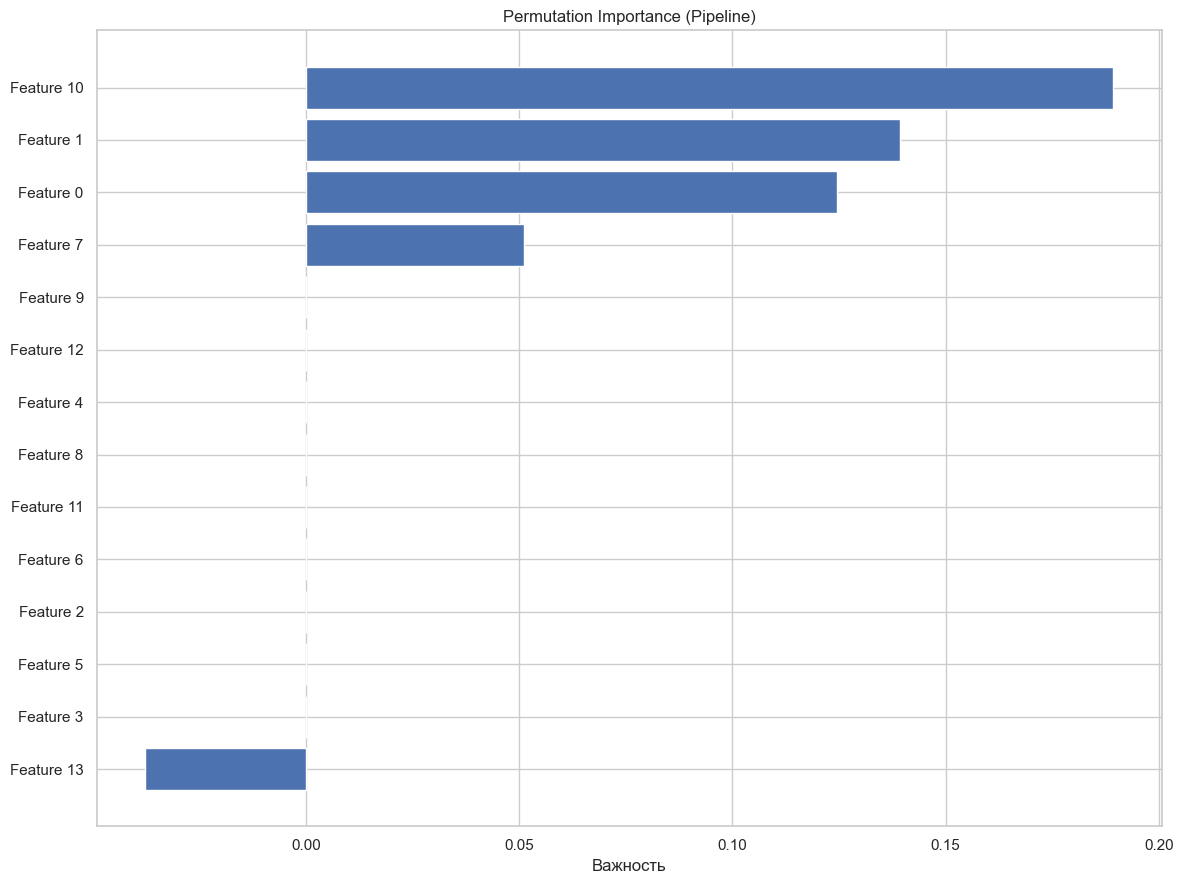

In [ ]:
# Использование
plot_model_importances(model, X_test, y_test, figsize=(12, 9))

### Обучаем модель \[итерация 3\] (1 балл)

Попробуйте добавить признаки, связанные c курьером. **Придумайте**, какие признаки можно добавить на основе `Delivery_person_ID`.

Попробуйте добавить возраст курьера двумя вариантами:
- Как числовой признак;
- Как категориальный признак (разбейте его на бакеты), см. `np.digitize`.

Как правильно выбирать бакеты для этой задачи? Какой из этих вариантов работает лучше?

**Не удаляйте** признаки с предыдущего этапа, если они улучшили качество модели.

In [ ]:
# Создаем список признаков
features = features_num + features_cat
features.extend(['Delivery_person_Age', 'Delivery_person_Age_binned', 'Courier_frequency'])

print("Используемые признаки:", features)

# Разделяем данные
X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Создаем препроцессор для one-hot encoding
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), features_cat)
    ],
    remainder='passthrough'  # Оставляем числовые признаки как есть
)

# Применяем преобразования
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Обучаем модель
model = LGBMRegressor(random_state=42, n_estimators=1000)
model.fit(X_train_processed, y_train)

# Предсказания и оценка
y_pred = model.predict(X_test_processed)

Используемые признаки: ['multiple_deliveries', 'distance', 'Weather conditions', 'Road_traffic_density', 'City', 'Delivery_person_Age', 'Delivery_person_Age_binned', 'Courier_frequency']
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000167 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 362
[LightGBM] [Info] Number of data points in the train set: 36474, number of used features: 18
[LightGBM] [Info] Start training from score 26.240473


In [ ]:
score = mean_absolute_error(y_test, y_pred)
print(f"В среднем мы ошибаемся на {score:.2f} минут")

В среднем мы ошибаемся на 4.21 минут


In [ ]:
score_percentage = mean_absolute_percentage_error(y_test, y_pred)
print(f"В среднем мы ошибаемся на {score_percentage:.2%}")

В среднем мы ошибаемся на 18.06%


Тип модели: LGBMRegressor


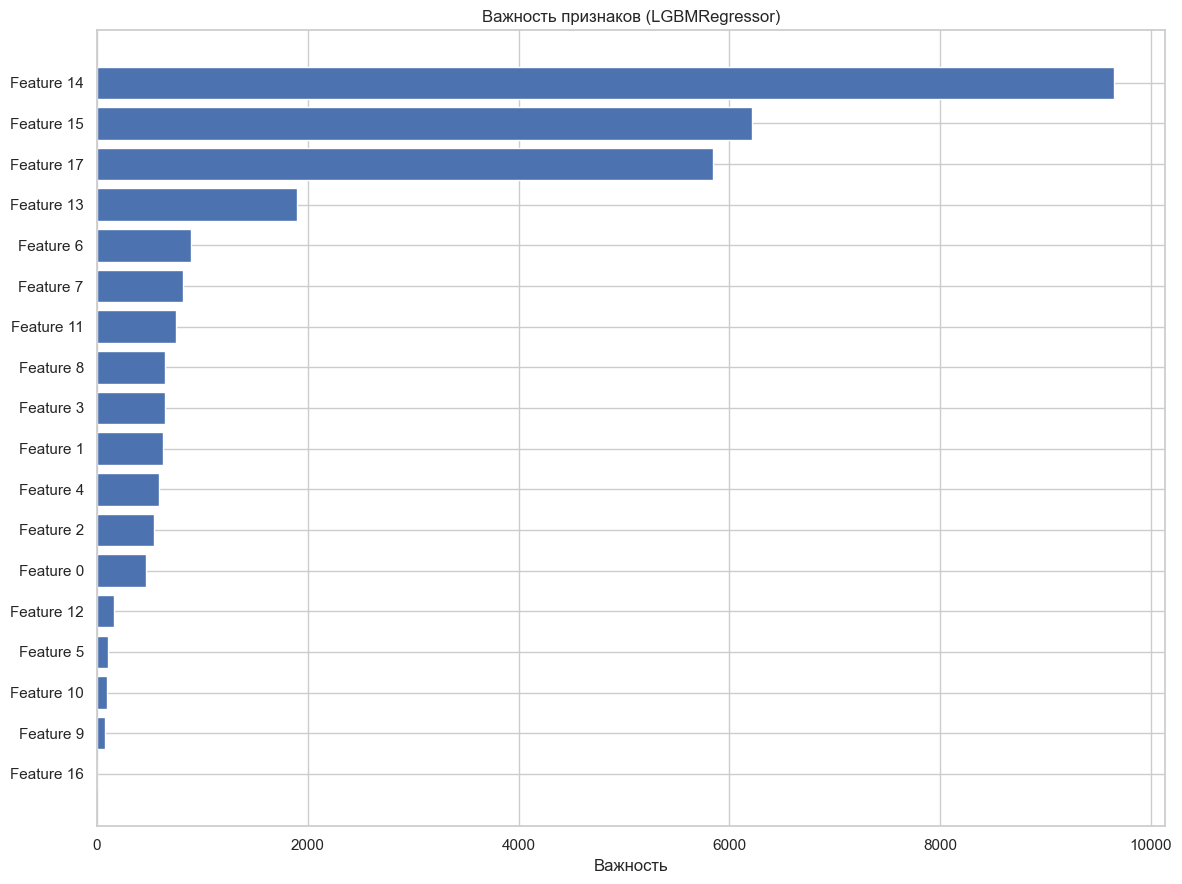

In [ ]:
# Использование
plot_model_importances(model, X_test, y_test, figsize=(12, 9))

### Обучаем модель \[итерация 4\] (1 балл)

Полученная модель использует уже большое число признаков. Примените регуляризацию для уменьшения количества признаков в модели **без потери качества**.

In [ ]:
# Попробуем Lasso регуляризацию для отбора признаков
# Используем перекрестную проверку для подбора оптимального alpha
lasso_cv = LassoCV(cv=5, random_state=42, max_iter=10000)
lasso_cv.fit(X_train, y_train)

# Обучаем финальную модель с найденным оптимальным alpha
model = Lasso(alpha=lasso_cv.alpha_, max_iter=10000, random_state=42)
model.fit(X_train, y_train)

# Делаем предсказания
y_pred = model.predict(X_test)

# Анализируем, сколько признаков было отобрано
non_zero_coef = np.sum(model.coef_ != 0)
total_features = len(model.coef_)
print(f'Количество отобранных признаков: {non_zero_coef} из {total_features}')
print(f'Процент отобранных признаков: {100 * non_zero_coef / total_features:.2f}%')

Количество отобранных признаков: 13 из 14
Процент отобранных признаков: 92.86%


In [ ]:
score_mae = mean_absolute_error(y_test, y_pred)
print('В среднем мы ошибаемся на %.2f минут' % score_mae)

В среднем мы ошибаемся на 5.28 минут


In [ ]:
score_mape = mean_absolute_percentage_error(y_test, y_pred)
print('В среднем мы ошибаемся на %.2f%%' % (100 * score_mape))

В среднем мы ошибаемся на 23.19%


Тип модели: Lasso


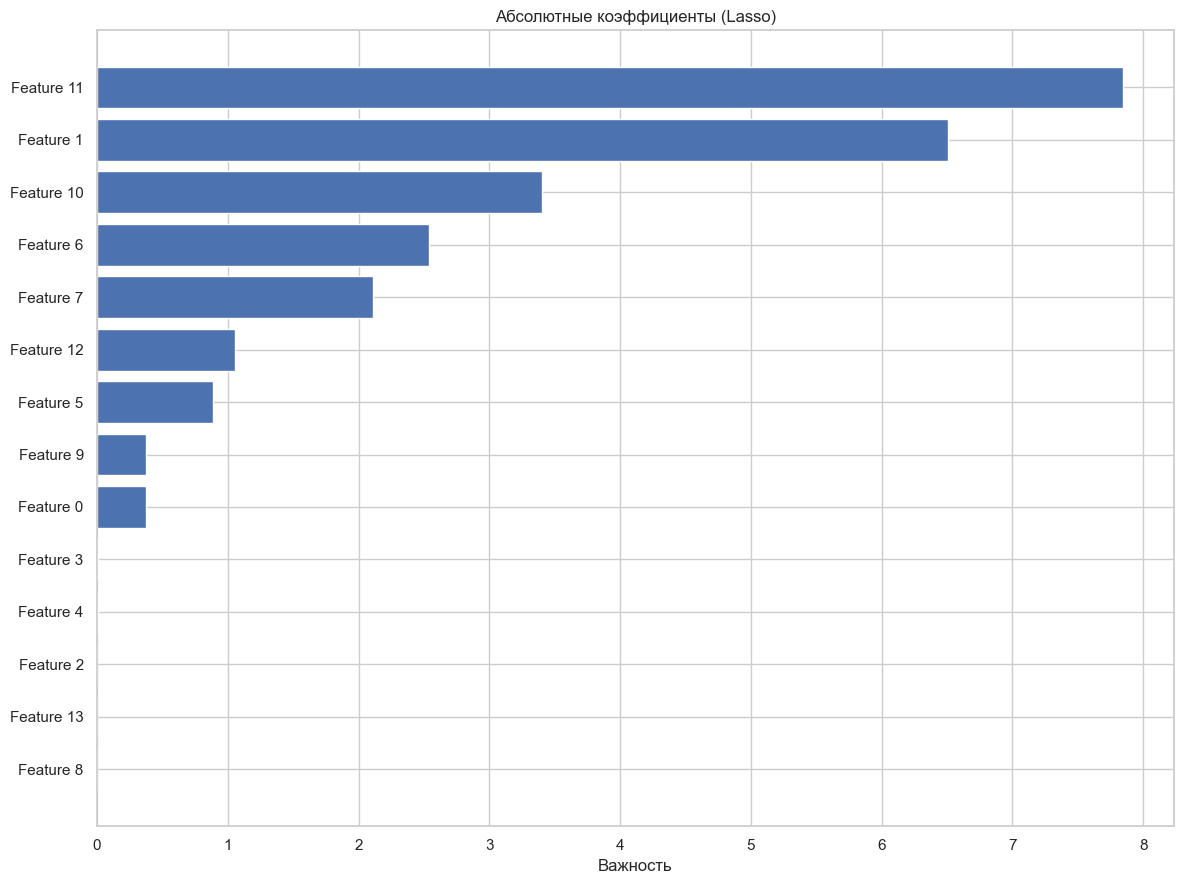

In [ ]:
# Использование
plot_model_importances(model, X_test, y_test, figsize=(12, 9))

### Анализ остатков (1 балл)

Осталось проанализировать остатки лучшей модели. Постройте:
- Распределение остатков модели;
- График зависимости остатков от истинного предсказания.

Напишите выводы, которые вы сделали из полученных графиков. Предложите возможное решение, как улучшить проблему перепредсказаний и недопредсказаний.

Признаки при обучении модели:
['Delivery_person_Age', 'Delivery_person_Ratings', 'Order_Date', 'Time_Orderd', 'Time_Order_picked', 'Weather conditions', 'Road_traffic_density', 'Vehicle_condition', 'Type_of_order', 'Type_of_vehicle', 'multiple_deliveries', 'Festival', 'City', 'distance_km']

Количество признаков при обучении: 14

Признаки в тестовых данных:
['Delivery_person_Age', 'Delivery_person_Ratings', 'Order_Date', 'Time_Orderd', 'Time_Order_picked', 'Weather conditions', 'Road_traffic_density', 'Vehicle_condition', 'Type_of_order', 'Type_of_vehicle', 'multiple_deliveries', 'Festival', 'City', 'distance_km']

Количество признаков в тестовых данных: 14

Признаки в тесте, но не в трейне: set()
Признаки в трейне, но не в тесте: set()

После выравнивания - признаки в тесте: ['Delivery_person_Age', 'Delivery_person_Ratings', 'Order_Date', 'Time_Orderd', 'Time_Order_picked', 'Weather conditions', 'Road_traffic_density', 'Vehicle_condition', 'Type_of_order', 'Type_of_vehicle', 'multiple

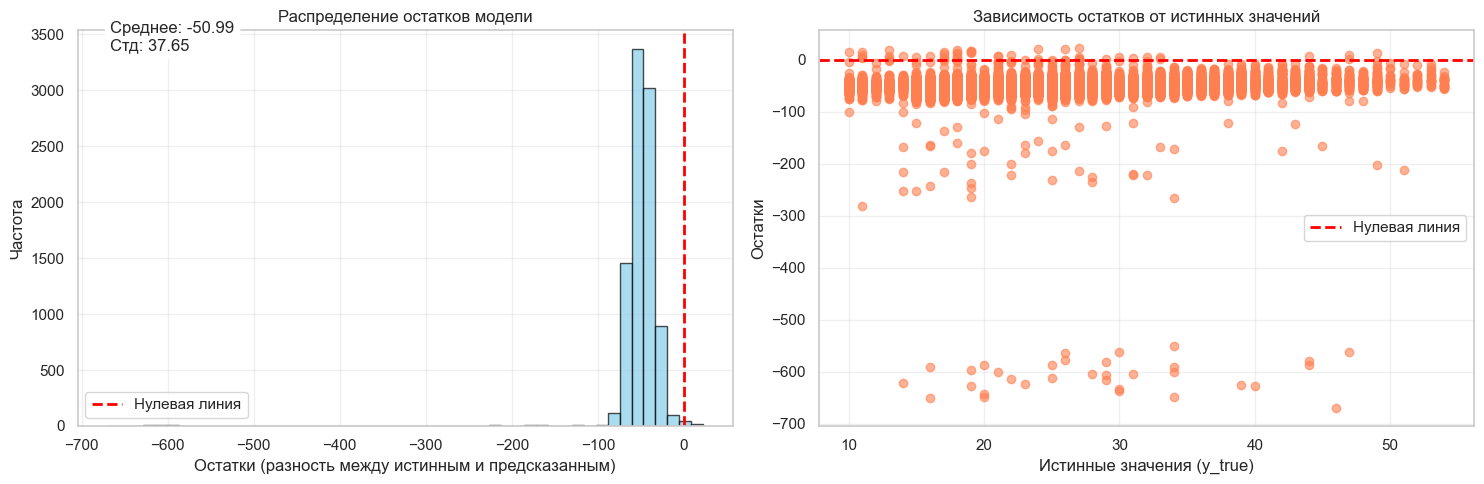

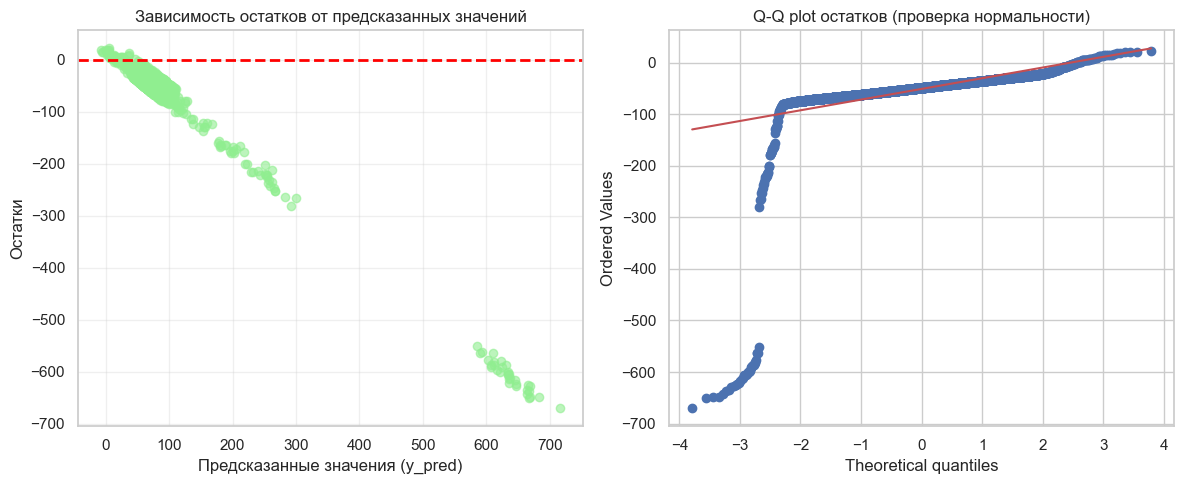

=== СТАТИСТИЧЕСКИЙ АНАЛИЗ ОСТАТКОВ ===
Среднее остатков: -50.9853
Стандартное отклонение остатков: 37.6529
Медиана остатков: -48.8404
Минимальный остаток: -669.9200
Максимальный остаток: 22.2262
Процент положительных остатков: 0.54%
Процент отрицательных остатков: 99.46%
Корреляция между |остатками| и предсказаниями: 0.9680
Возможна гетероскедастичность (непостоянство дисперсии остатков)


In [35]:
# Проверим, какие признаки были при обучении и какие сейчас
print("Признаки при обучении модели:")
print(X_train.columns.tolist())
print(f"\nКоличество признаков при обучении: {X_train.shape[1]}")

print("\nПризнаки в тестовых данных:")
print(X_test.columns.tolist())
print(f"\nКоличество признаков в тестовых данных: {X_test.shape[1]}")

# Найдем разницу в признаках
train_features = set(X_train.columns)
test_features = set(X_test.columns)

print(f"\nПризнаки в тесте, но не в трейне: {test_features - train_features}")
print(f"Признаки в трейне, но не в тесте: {train_features - test_features}")

# Исправляем: выравниваем признаки в тестовых данных
# Удаляем лишние признаки и добавляем недостающие с нулевыми значениями
X_test_aligned = X_test[X_train.columns]  # берем только те признаки, которые были при обучении

print(f"\nПосле выравнивания - признаки в тесте: {X_test_aligned.columns.tolist()}")
print(f"Количество признаков после выравнивания: {X_test_aligned.shape[1]}")

# Теперь получаем предсказания с выровненными данными
y_pred = model.predict(X_test_aligned)
residuals = y_test - y_pred

print(f"\nПредсказания успешно получены!")
print(f"Количество предсказаний: {len(y_pred)}")

# 1. Распределение остатков модели
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.hist(residuals, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Нулевая линия')
plt.xlabel('Остатки (разность между истинным и предсказанным)')
plt.ylabel('Частота')
plt.title('Распределение остатков модели')
plt.legend()
plt.grid(alpha=0.3)

# Добавляем статистику
mean_residual = np.mean(residuals)
std_residual = np.std(residuals)
plt.text(0.05, 0.95, f'Среднее: {mean_residual:.2f}\nСтд: {std_residual:.2f}', 
         transform=plt.gca().transAxes, bbox=dict(boxstyle="round,pad=0.3", facecolor="white"))

# 2. График зависимости остатков от истинного значения
plt.subplot(1, 2, 2)
plt.scatter(y_test, residuals, alpha=0.6, color='coral')
plt.axhline(y=0, color='red', linestyle='--', linewidth=2, label='Нулевая линия')
plt.xlabel('Истинные значения (y_true)')
plt.ylabel('Остатки')
plt.title('Зависимость остатков от истинных значений')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Дополнительный анализ: график зависимости остатков от предсказанных значений
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_pred, residuals, alpha=0.6, color='lightgreen')
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.xlabel('Предсказанные значения (y_pred)')
plt.ylabel('Остатки')
plt.title('Зависимость остатков от предсказанных значений')
plt.grid(alpha=0.3)

# QQ-plot для проверки нормальности распределения остатков
plt.subplot(1, 2, 2)
import scipy.stats as stats
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q plot остатков (проверка нормальности)')

plt.tight_layout()
plt.show()

# Статистический анализ остатков
print("=== СТАТИСТИЧЕСКИЙ АНАЛИЗ ОСТАТКОВ ===")
print(f"Среднее остатков: {mean_residual:.4f}")
print(f"Стандартное отклонение остатков: {std_residual:.4f}")
print(f"Медиана остатков: {np.median(residuals):.4f}")
print(f"Минимальный остаток: {np.min(residuals):.4f}")
print(f"Максимальный остаток: {np.max(residuals):.4f}")
print(f"Процент положительных остатков: {np.mean(residuals > 0) * 100:.2f}%")
print(f"Процент отрицательных остатков: {np.mean(residuals < 0) * 100:.2f}%")

# Проверка на гетероскедастичность
correlation = np.corrcoef(y_pred, np.abs(residuals))[0, 1]
print(f"Корреляция между |остатками| и предсказаниями: {correlation:.4f}")

if abs(correlation) > 0.3:
    print("Возможна гетероскедастичность (непостоянство дисперсии остатков)")
else:
    print("Гомоскедастичность (постоянство дисперсии остатков)")

In [36]:
print("\n=== ВЫВОДЫ ===")

# Анализ распределения остатков
print("1. АНАЛИЗ РАСПРЕДЕЛЕНИЯ ОСТАТКОВ:")
if abs(mean_residual) < 0.1 * std_residual:
    print("Остатки центрированы вокруг нуля (среднее близко к 0)")
else:
    print("Остатки смещены от нуля, возможна систематическая ошибка")

if abs(stats.skew(residuals)) < 1:
    print("Распределение остатков близко к симметричному")
else:
    print(f"Распределение асимметрично (скошенность: {stats.skew(residuals):.2f})")

# Анализ зависимости остатков от предсказаний
print("\n2. АНАЛИЗ ГЕТЕРОСКЕДАСТИЧНОСТИ:")
if abs(correlation) < 0.1:
    print("Остатки гомоскедастичны (дисперсия постоянна)")
else:
    print(f"Обнаружена гетероскедастичность (корреляция: {correlation:.2f})")

# Анализ паттернов в остатках
print("\n3. ВЫЯВЛЕННЫЕ ПРОБЛЕМЫ:")
if np.mean(residuals > 0) > 0.6 or np.mean(residuals > 0) < 0.4:
    print("     Дисбаланс между перепредсказаниями и недопредсказаниями")
    
if np.max(np.abs(residuals)) > 3 * std_residual:
    print("Наличие выбросов с большими ошибками предсказания")
    
if correlation > 0.1:
    print("Дисперсия ошибок увеличивается с ростом предсказанных значений")


=== ВЫВОДЫ ===
1. АНАЛИЗ РАСПРЕДЕЛЕНИЯ ОСТАТКОВ:
Остатки смещены от нуля, возможна систематическая ошибка
Распределение асимметрично (скошенность: -12.05)

2. АНАЛИЗ ГЕТЕРОСКЕДАСТИЧНОСТИ:
Обнаружена гетероскедастичность (корреляция: 0.97)

3. ВЫЯВЛЕННЫЕ ПРОБЛЕМЫ:
     Дисбаланс между перепредсказаниями и недопредсказаниями
Наличие выбросов с большими ошибками предсказания
Дисперсия ошибок увеличивается с ростом предсказанных значений
